# Group Details
## Group Name:
### Student 1:
### Student 2:
### Student 3:

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [4]:
TRAIN_1 = False
TRAIN_2 = True
TRAIN_3 = False
GRID_SEARCH_1 = False
GRID_SEARCH_2 = False

In [5]:
def load_trajectory(filename, task):
    """
    This function loads a trajectory from a given file and returns the trajectory and energy data. 
    If the task is 'task_3', it also returns the framework data.

    Parameters:
    filename (str): The name of the file from which to load the trajectory.
    task (str): The task for which the trajectory is being loaded. 
                This should be one of 'task_1', 'task_2', or 'task_3'.

    Returns:
    tuple: Depending on the task, the function returns:
           - (trajectory, energy) for 'task_1' and 'task_2'
           - (trajectory, framework, energy) for 'task_3'
    """
    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [6]:
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


In [7]:
x_0 = trajectory[0][0][0]
y_0 = trajectory[0][0][1]
print(f'Initial position: {x_0}, {y_0} Blue')

Initial position: 9.595544088638388, 7.531951993028981 Blue


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

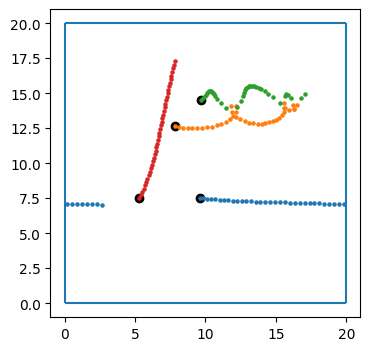

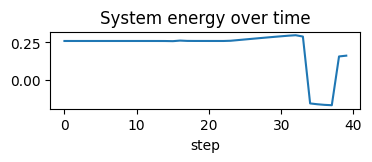

In [8]:
def plot_trajectory_energy(trajectory, energy):
    """
    This function plots the trajectory of a system and its energy over time.

    Parameters:
    trajectory (numpy.ndarray): A 2D array representing the trajectory of the system. 
                                The first dimension represents time, and the second dimension represents the x and y coordinates.
    energy (numpy.ndarray): A 1D array representing the energy of the system at each time step.

    The function first plots the trajectory on a 2D grid, with the x and y coordinates on the x and y axes respectively. 
    The initial position is marked in black. The trajectory is represented by a scatter plot, with each point representing the position at a different time step.

    Then, the function plots the energy of the system over time on a separate graph. The x-axis represents the time step, and the y-axis represents the energy.
    """
    
    x = trajectory[...,0]
    y = trajectory[...,1]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()
    plt.figure(figsize=(4,1))
    plt.plot(energy)
    plt.xlabel('step')
    plt.title('System energy over time')
    plt.show();

plot_trajectory_energy(trajectory, energy)

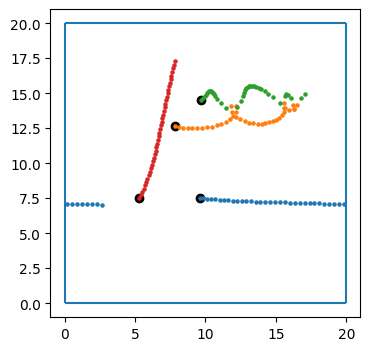

In [9]:
def plot_trajectory(trajectory):
    """
    This function plots the trajectory of a system and its energy over time.

    Parameters:
    trajectory (numpy.ndarray): A 2D array representing the trajectory of the system. 
                                The first dimension represents time, and the second dimension represents the x and y coordinates.
    energy (numpy.ndarray): A 1D array representing the energy of the system at each time step.

    The function first plots the trajectory on a 2D grid, with the x and y coordinates on the x and y axes respectively. 
    The initial position is marked in black. The trajectory is represented by a scatter plot, with each point representing the position at a different time step.

    Then, the function plots the energy of the system over time on a separate graph. The x-axis represents the time step, and the y-axis represents the energy.
    """
    
    x = trajectory[...,0]
    y = trajectory[...,1]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()

plot_trajectory(trajectory)

# Task 1

Implement task 1 below. Feel free to add extra code cells for different components of your implementation.

## Data Processing

In [10]:
def minimum_image_distance(pos1, pos2, box_length):
    """
    Compute the distance between two points with the minimum image convention.

    Parameters:
    pos1, pos2: numpy arrays representing the positions of the two points.
    box_length: float representing the length of one side of the box.

    Returns:
    float representing the distance between the two points.
    """
    delta = pos2 - pos1
    delta = delta - box_length * np.round(delta / box_length)
    return np.sqrt(np.sum(delta**2))

In [11]:
from torch_geometric.data import Data

def create_graph_from_particles(particles, energy, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a graph representation of a system of particles for use in graph neural networks. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle, 
                               and the remaining columns representing additional features of the particle.
    energy (float): The energy of the system.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    torch_geometric.data.Data: A Data object representing the graph. 
                               The node features, edge indices, edge attributes, and energy are stored as attributes of this object.

    The function first creates a list of node features and a list of edge indices and attributes. 
    Then, it converts these lists into PyTorch tensors and creates a Data object from them. 
    Finally, it validates the Data object to ensure that it is correctly formatted.
    """

    
    num_particles = particles.shape[0]
    x = particles[:, 2:] # Position is not used as node feature

    edge_index = []
    edge_attr = []
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:  # Avoid self-loops

                # Append edge if distance is below cutoff
                pos1 = particles[i, :2]
                pos2 = particles[j, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)
                
                edge_index.append([i, j])
                if distance < cutoff_value: # TODO Per essere corretto non bisognerebbe creare l'edge se la distanza è maggiore del cutoff, ma facendo cosi ci sono errori in alcuni casi limite (annuncio canvas). Ho messo quindi rami con pesi negativi (distanze) per gli edge che non dovrebbero esistere. In questo modo il modello dovrebbe imparare a non considerarli.
                    edge_attr.append(distance)
                else:
                    edge_attr.append(-1.0) # Use -1.0 as padding value

    x = torch.tensor(x, dtype=torch.float)         
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    energy = torch.tensor(energy, dtype=torch.float)

    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=energy)

    # Validate data object
    data.validate(raise_on_error=True)
    
    return data


def create_particle_data_list(trajectory, energies, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a list of graph representations of a system of particles for each time step in a trajectory. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    trajectory (numpy.ndarray): A 3D array representing the trajectory of the system. 
                                The first dimension represents time, the second dimension represents particles, 
                                and the third dimension represents the x and y coordinates of the particles.
    energies (numpy.ndarray): A 1D array representing the energy of the system at each time step.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    list: A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.

    The function iterates over each time step in the trajectory, creating a graph for each one and appending it to the list. 
    The graphs are created using the create_graph_from_particles function.
    """
    particle_data_list = []
    for i in range(trajectory.shape[0]):
        particles = trajectory[i]
        energy = energies[i]
        particle_data_list.append(create_graph_from_particles(particles, energy, box_length, cutoff_value))
    return particle_data_list

particle_data_list = create_particle_data_list(trajectory, energy)
particles = trajectory[0]
particles_graph = particle_data_list[0]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Particles graph:\n {particles_graph}')

Particles ((4, 5)):
 [[ 9.59554409  7.53195199  0.51611651 -0.06928145 -1.        ]
 [ 7.84276225 12.65405926  0.5342578  -0.12193773  1.        ]
 [ 9.71213475 14.49577317  0.28795482  0.33377239 -1.        ]
 [ 5.2803654   7.53604669  0.25443658  0.42087594 -1.        ]]
Particles graph:
 Data(x=[4, 3], edge_index=[2, 12], edge_attr=[12], y=[1])


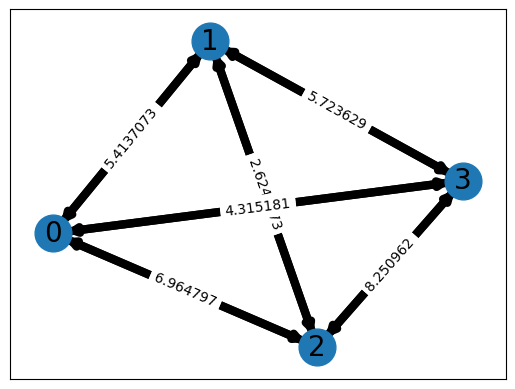

In [12]:
import networkx as nx

def visualize_graph(data):
    """
    This function visualizes a graph represented by a PyTorch Geometric Data object using NetworkX and Matplotlib.
    This function is used to check the correctness of the graph creation process.

    Parameters:
    data (torch_geometric.data.Data): A Data object representing the graph. 
                                      The node features, edge indices, and edge attributes are stored as attributes of this object.

    The function first creates a NetworkX DiGraph object and adds nodes and edges to it based on the edge indices and edge attributes in the Data object. 
    The edges are weighted based on the edge attributes.

    Then, the function uses NetworkX's spring layout algorithm to calculate the positions of the nodes, and draws the nodes, edges, and labels using Matplotlib.

    Finally, the function displays the graph using Matplotlib's pyplot.show() function.
    """
    edge_index = data.edge_index.cpu().numpy()
    edge_attr = data.edge_attr.cpu().numpy() 
    num_nodes = data.x.shape[0]

    # Create a networkx graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges with weights
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        weight = edge_attr[i] 
        G.add_edge(src, dst, weight=weight)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, width=6)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

    # edge labels
    edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('on')
    plt.show()

visualize_graph(particles_graph)

In [13]:
# Compute distances between all pairs of nodes
def compute_distances(particles, box_length=20):
    """
    This function computes the distances between all pairs of particles in a system, taking into account the periodic boundary conditions of the system.
    This function is used to check the correctness of the edge attributes in the graph representation of the system.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.

    Returns:
    numpy.ndarray: A 2D array representing the distance between each pair of particles. 
                   The element at the i-th row and j-th column represents the distance between the i-th and j-th particles.

    The function first initializes a 2D array of zeros with a size equal to the number of particles. 
    Then, it iterates over each pair of particles, calculates the minimum image distance between them, 
    and stores the result in the corresponding element of the distance array. 
    Since the distance between the i-th and j-th particles is the same as the distance between the j-th and i-th particles, 
    the function only calculates the distance once for each pair of particles.
    """
    num_particles = len(particles)
    distances = np.zeros((num_particles, num_particles))

    for i in range(num_particles):
        pos_1 = particles[i, :2]
        for j in range(i+1, num_particles):
            pos_2 = particles[j, :2]
            distances[i, j] = minimum_image_distance(pos_1, pos_2, box_length)
            distances[j, i] = distances[i, j]  # The distance matrix is symmetric

    return distances

particles = trajectory[0]
distances = compute_distances(particles)
distances


array([[0.        , 5.41370733, 6.96479711, 4.31518063],
       [5.41370733, 0.        , 2.62420725, 5.72362912],
       [6.96479711, 2.62420725, 0.        , 8.2509619 ],
       [4.31518063, 5.72362912, 8.2509619 , 0.        ]])

In [14]:
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    """
    A PyTorch Dataset for representing a system of particles. 
    The dataset is created from a list of file paths, each of which contains a trajectory of the system.

    Attributes:
    file_paths (list): A list of file paths from which to load the trajectories.
    task (str): The task for which the dataset is being created. This should be one of 'task_1', 'task_2', or 'task_3'.
    max_len (int): The maximum number of particles in the system.
    box_length (float, optional): The length of the box in which the particles are contained. Defaults to 20.0.
    cutoff (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.
    data_list (list): A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.
    """
    def __init__(self, file_paths, max_len, box_length=20.0, cutoff=10.0):
        """
        Initializes the ParticleDataset with the given file paths, task, maximum number of particles, box length, and cutoff distance.
        """
        self.file_paths = file_paths
        self.max_len = max_len
        self.box_length = box_length
        self.cutoff = cutoff
        self.data_list = []
        self.task = "task_1"
        for file_path in tqdm(file_paths):
            trajectory, energy = load_trajectory(file_path, self.task)
            particle_data_list = create_particle_data_list(trajectory, energy, self.box_length, self.cutoff)
            self.data_list += particle_data_list
    
    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]
    


In [15]:
from sklearn.model_selection import train_test_split
import glob
import os
import pickle

# Define the paths and parameters
file_paths = glob.glob('data/task1_2/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges
task = 'task_1'  # The task to perform
batch_size = 1  # The batch size

train_len = len(file_paths) * 0.8
train_file_paths = file_paths[:int(train_len)]
val_file_paths = file_paths[int(train_len):]

# Check if the datasets are already saved
if os.path.exists('train_dataset_task_1.pkl') and os.path.exists('val_dataset_task_1.pkl'):
    # Load the datasets
    print('Loading datasets...')
    with open('train_dataset_task_1.pkl', 'rb') as f:
        train_dataset = pickle.load(f)
    with open('val_dataset_task_1.pkl', 'rb') as f:
        val_dataset = pickle.load(f)
else:
    # Create datasets
    print('Creating datasets...')
    train_dataset = ParticleDataset(train_file_paths, max_len, box_length, cutoff)
    val_dataset = ParticleDataset(val_file_paths, max_len, box_length, cutoff)

    # Save the datasets
    with open('train_dataset_task_1.pkl', 'wb') as f:
        pickle.dump(train_dataset, f)
    with open('val_dataset_task_1.pkl', 'wb') as f:
        pickle.dump(val_dataset, f)

print(f'Train dataset: {len(train_dataset)} samples')
print(f'Validation dataset: {len(val_dataset)} samples')

Loading datasets...
Train dataset: 28800 samples
Validation dataset: 7200 samples


In [16]:
train_dataset[0]

Data(x=[3, 3], edge_index=[2, 6], edge_attr=[6], y=[1])

In [17]:
from torch_geometric.loader import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for data in train_loader:
    print(data)
    break

DataBatch(x=[4, 3], edge_index=[2, 12], edge_attr=[12], y=[1], batch=[4], ptr=[2])


## Model Definition

In [18]:
import torch.nn as nn

class Node_to_emb(nn.Module):
    """
    This class is a PyTorch module that transforms node features into node embeddings using a linear transformation.

    Attributes:
    emb (nn.Linear): A linear transformation layer.
    """
    def __init__(self, node_feat_dim=5, node_emb_dim=64):
        """
        Initializes the Node_to_emb with the given dimensions for the node features and node embeddings.
        """
        super(Node_to_emb, self).__init__()
        self.emb = nn.Linear(node_feat_dim, node_emb_dim)

    def forward(self, nodes):
        """
        Transforms the given node features into node embeddings using the linear transformation layer.
        """
        assert nodes.size(-1) == self.emb.in_features, 'wrong input dimension of node features!'
        return self.emb(nodes)

class MpLayer(nn.Module):
    """
    This class is a PyTorch module that represents a message passing layer in a graph neural network.

    Attributes:
    edge_network (nn.Sequential): A sequence of layers that transform the edge features.
    node_network (nn.Sequential): A sequence of layers that transform the node features.
    """
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        """
        Initializes the MpLayer with the given hidden dimension and activation function.
        """
        super(MpLayer, self).__init__()
        self.edge_network = nn.Sequential(
            nn.Linear(2*hidden_dim + 1, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation
        )
        self.node_network = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, node_tensor, edge_idx_tensor, edge_attr_tensor):
        """
        Performs the forward pass of the message passing layer.
        """
        edge_messages_input = torch.cat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1)
        
        edge_attr_tensor = edge_attr_tensor.unsqueeze(-1)
        edge_messages_input = torch.cat([edge_messages_input, edge_attr_tensor], dim=-1)
    
        edge_messages_output = self.edge_network(edge_messages_input)
        
        node_agg_messages = torch.zeros_like(node_tensor).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))
        return node_out, edge_idx_tensor

class MpGNN(nn.Module):
    """
    This class is a PyTorch module that represents a message passing graph neural network.

    Attributes:
    node_to_emb (Node_to_emb): A module that transforms node features into node embeddings.
    mp_layers (nn.ModuleList): A list of message passing layers.
    to_pred (nn.Linear): A linear transformation layer that transforms the output of the last message passing layer into the final output.
    """
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_layers=3):
        """
        Initializes the MpGNN with the given dimensions for the node features and hidden layer, activation function, and number of layers.
        """
        super(MpGNN, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        self.to_pred = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Performs the forward pass of the graph neural network.
        """
        x = self.node_to_emb(x)
        for layer in self.mp_layers:
            x, edge_index = layer(x, edge_index, edge_attr)
        
        out = torch.zeros(batch.max().item() + 1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand_as(x)
        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x)
        
        out = self.to_pred(out)
        return out

In [19]:
num_features = int(train_dataset[0].x.shape[1])
num_features

3

In [20]:
from torch.optim import Adam
from torch_geometric.nn import summary

# Hyperparameters
hidden_dim = 64
num_layers = 7
learning_rate = 0.0001
weight_decay = 0
num_epochs = 20

# Initialize the model, optimizer and loss function
model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers).to(device) # initialize  GNN

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

dummy_data = next(iter(train_loader))
print(summary(model, dummy_data.x, dummy_data.edge_index, dummy_data.edge_attr, dummy_data.batch))


+--------------------------------------+----------------------------+------------------+----------+
| Layer                                | Input Shape                | Output Shape     | #Param   |
|--------------------------------------+----------------------------+------------------+----------|
| MpGNN                                | [4, 3], [2, 12], [12], [4] | [1, 1]           | 174,593  |
| ├─(node_to_emb)Node_to_emb           | [4, 3]                     | [4, 64]          | 256      |
| │    └─(emb)Linear                   | [4, 3]                     | [4, 64]          | 256      |
| ├─(mp_layers)ModuleList              | --                         | --               | 174,272  |
| │    └─(0)MpLayer                    | [4, 64], [2, 12], [12]     | [4, 64], [2, 12] | 24,896   |
| │    │    └─(edge_network)Sequential | [12, 129]                  | [12, 64]         | 12,480   |
| │    │    └─(node_network)Sequential | [4, 128]                   | [4, 64]          | 12,416   |


## Training

In [21]:
def train(model, train_loader, optimizer, criterion, device):
    """
    This function trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to train.
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function to use for training.
    device (torch.device): The device to use for training.

    The function first sets the model to training mode. Then, it iterates over the training data. For each batch of data, 
    it moves the data to the given device, performs a forward pass, computes the loss, performs a backward pass, 
    and updates the model parameters. The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.train()
    total_loss = 0
    for data in train_loader:
        
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
       
        loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """
    This function validates the given model using the given data loader, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to validate.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    criterion (torch.nn.Module): The loss function to use for validation.
    device (torch.device): The device to use for validation.

    The function first sets the model to evaluation mode. Then, it iterates over the validation data. 
    For each batch of data, it moves the data to the given device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Train model
if TRAIN_1:
    train_losses = []
    val_losses = []

    # Initialize best validation loss to infinity
    best_val_loss = float('inf')

    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save the model if it's the best one so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_task_1.pth')

    print(f'Best Val Loss: {best_val_loss}')


In [22]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    """
    This function plots the training and validation losses over epochs.

    Parameters:
    train_losses (list): A list of training losses for each epoch.
    val_losses (list): A list of validation losses for each epoch.

    The function uses matplotlib to create a line plot of the training and validation losses. 
    The x-axis represents the epoch number and the y-axis represents the loss. 
    The training losses are plotted in one color and the validation losses are plotted in another color. 
    A legend is added to the plot to distinguish between the two lines. 
    Finally, the plot is displayed.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if TRAIN_1:
    plot_losses(train_losses, val_losses)

## Test

In [23]:
# Load the best model
model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers)
model.load_state_dict(torch.load('best_model_task_1.pth'))

<All keys matched successfully>

In [24]:
# Load and preprocess test data
test_file_paths = glob.glob('data/task1_2/test/*.npz')

test_dataset = ParticleDataset(test_file_paths, max_len, box_length, cutoff)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f'Test dataset: {len(test_dataset)} samples')

100%|██████████| 100/100 [00:00<00:00, 160.02it/s]

Test dataset: 4000 samples


In [25]:
def compute_test_loss(model, test_loader, criterion):
    """
    This function computes the loss of the given model on the given test data using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to test.
    test_loader (torch.utils.data.DataLoader): The data loader that provides the test data.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the test data. 
    For each batch of data, it moves the data to the device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    return total_loss / len(test_loader)

compute_test_loss(model, test_loader, criterion)

0.048849550288140885

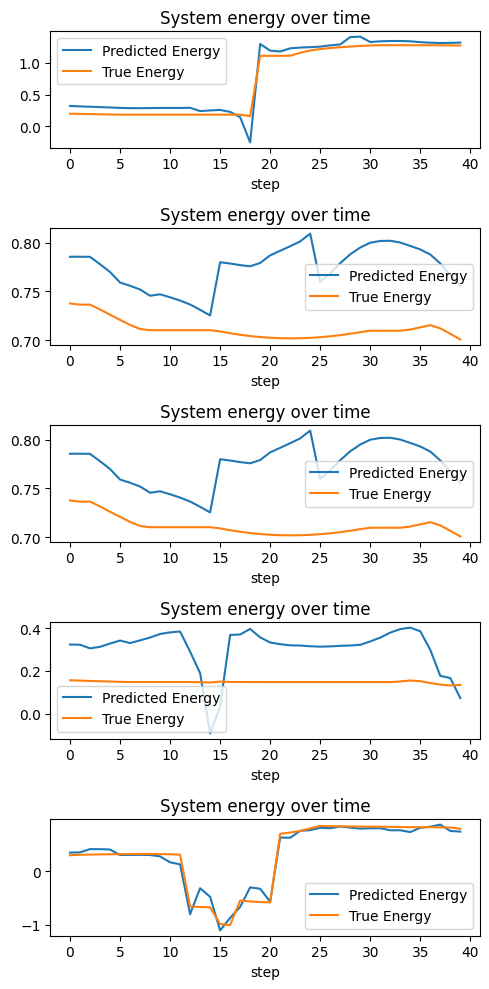

In [26]:
from torch_geometric.data import Batch

def plot_predictions(model, file_paths, device, task, num_plots=5, box_length=20.0, cutoff_value=10.0):
    """
    This function plots the predicted and true energies over time for a random selection of systems from the given file paths.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    file_paths (list): A list of file paths to the system data.
    device (torch.device): The device to use for prediction.
    task (str): The task to perform (e.g., 'classification', 'regression').
    num_plots (int, optional): The number of plots to create. Default is 5.
    box_length (float, optional): The length of the box in which the particles are contained. Default is 20.0.
    cutoff_value (float, optional): The cutoff value for the interaction between particles. Default is 10.0.

    The function first sets the model to evaluation mode. Then, it selects a random subset of the file paths. 
    For each selected file path, it loads the system data, creates a graph from the system data, 
    and uses the model to predict the energies of the system over time. 
    It then plots the predicted energies and the true energies on the same plot. 
    The x-axis represents the time step and the y-axis represents the energy. 
    A legend is added to the plot to distinguish between the predicted and true energies. 
    Finally, the function displays all the plots.
    """
    model.eval()
    random_indices = np.random.randint(0, len(file_paths), size=num_plots)
    random_paths = [file_paths[i] for i in random_indices]

    fig, axs = plt.subplots(num_plots, 1, figsize=(5, num_plots*2))

    with torch.no_grad():
        plot_count = 0
        for i, path in enumerate(random_paths):
            
            trajectory, energy = load_trajectory(path, task)
           
            # Create a graph from the trajectory
            particles_list = create_particle_data_list(trajectory, energy, box_length, cutoff_value)
            batched_data = Batch.from_data_list(particles_list).to(device)

            output = model(batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch)

            # Plot predicted energies
            axs[plot_count].plot(output.cpu(), label='Predicted Energy')

            # Plot true energies
            axs[plot_count].plot(energy.flatten(), label='True Energy')

            axs[plot_count].set_xlabel('step')
            axs[plot_count].set_title('System energy over time')
            axs[plot_count].legend()

            
            plot_count += 1
            if plot_count == num_plots:
                break

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_file_paths, device, task)


## Tuning

In [27]:
import itertools

def grid_search(train_loader, val_loader, num_features, num_epochs, device, output_file):
    """
    This function performs a grid search over a set of hyperparameters to find the best model for the given training and validation data.

    Parameters:
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    num_features (int): The number of features in the input data.
    num_epochs (int): The number of epochs to train each model.
    device (torch.device): The device to use for training and validation.
    output_file (str): The path to the file where the grid search results will be written.

    The function iterates over all combinations of the hyperparameters. For each combination, it creates a model with the current hyperparameters, 
    trains the model for the given number of epochs, and computes the validation loss. 
    If the validation loss is lower than the best validation loss seen so far, the function updates the best model, best validation loss, and best hyperparameters. 
    The function writes the hyperparameters and validation loss of each model to the output file. 
    Finally, the function returns the best model, best hyperparameters, and best validation loss.
    """
    
    # Define hyperparameters to tune
    hidden_dims = [32, 64, 128, 256]
    num_layers_list = [5, 7, 9]
    learning_rates = [0.0001, 0.001]
    weight_decays = [0.0, 1e-5]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    with open(output_file, 'w') as f:
        f.write("hidden_dim,num_layers,lr,weight_decay,val_loss\n")

        for hidden_dim, num_layers, lr, weight_decay in tqdm(itertools.product(hidden_dims, num_layers_list, learning_rates, weight_decays)):
            # Create model with current hyperparameters
            model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN
            # Define optimizer and criterion
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = torch.nn.MSELoss()

            best_model_loss = float('inf')

            # Train model
            print(f'Starting training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}')
            for epoch in range(num_epochs):
                train_loss = train(model, train_loader, optimizer,criterion, device)
                val_loss = validate(model, val_loader, criterion, device)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'hidden_dim': hidden_dim, 'num_layers': num_layers, 'lr': lr, 'weight_decay': weight_decay}
                    torch.save(best_model.state_dict(), 'best_model_grid_search.pth')

                if val_loss < best_model_loss:
                    best_model_loss = val_loss

            f.write(f"{hidden_dim},{num_layers},{lr},{weight_decay},{best_model_loss}\n")
            print(f"Finished training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}, val_loss={best_model_loss}")
     
    return best_model, best_params, best_val_loss


num_epochs = 20

if GRID_SEARCH_1:
    output_file = "grid_search_results.txt"
    best_model, best_params, best_val_loss = grid_search(train_loader, val_loader, num_features, num_epochs, device, output_file)
    torch.save(best_model.state_dict(), 'best_model_grid_search_1.pth')
    print("Best Parameters:")
    print(best_params)
    print("Best Validation Loss:", best_val_loss)

Best Parameters: {'hidden_dim': 64, 'num_layers': 7, 'lr': 0.0001, 'weight_decay': 0}

Best Validation Loss: 0.215618465204782

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

## Preprocessing

In [28]:
from torch_geometric.data import Data

def create_graph_from_particles_task_2(particles, next_particles=None, energy=0.0, next_energy=0.0, box_length=20.0, cutoff_value=10.0):

    # TODO: Remove energy????
    
    num_particles = particles.shape[0]

    velocity_x = particles[:, 2]
    velocity_y = particles[:, 3]
    charge = particles[:, 4][:, np.newaxis]
    
    velocity_norm = np.sqrt(velocity_x**2 + velocity_y**2)

    edge_index = []
    edge_attr = [] # Distance and charge product
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:  # Avoid self-loops

                # Charge product
                charge_1 = charge[i]    
                charge_2 = charge[j]
                charge_product = charge_1 * charge_2

                # Append edge if distance is below cutoff
                pos1 = particles[i, :2]
                pos2 = particles[j, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)
                
                edge_index.append([i, j])

                if distance < cutoff_value: # TODO Per essere corretto non bisognerebbe creare l'edge se la distanza è maggiore del cutoff, ma facendo cosi ci sono errori in alcuni casi limite (annuncio canvas). Ho messo quindi rami con pesi negativi (distanze) per gli edge che non dovrebbero esistere. In questo modo il modello dovrebbe imparare a non considerarli.
                    edge_attr.append([distance, charge_product.item()])
                else:
                    # Use -999.0 as padding value
                    edge_attr.append([-999.0, -999.0]) # TODO change padding value if needed
    
    
    x = torch.tensor(velocity_norm, dtype=torch.float).unsqueeze(-1) # Use velocity norm as node feature
    edge_index = torch.tensor(edge_index).t().contiguous()
    # edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float) 

    coordinates = torch.tensor(particles[:, :2], dtype=torch.float)
    velocity = torch.tensor(particles[:, 2:4], dtype=torch.float)
    # energy = torch.tensor(energy, dtype=torch.float)

    if next_particles is not None: # For train set

        next_position_x = next_particles[:, 0][:, np.newaxis]
        next_position_y = next_particles[:, 1][:, np.newaxis]

        next_velocity_x = next_particles[:, 2][:, np.newaxis]
        next_velocity_y = next_particles[:, 3][:, np.newaxis]

        target = np.concatenate([next_position_x, next_position_y, next_velocity_x, next_velocity_y], axis=1)
        target = torch.tensor(target, dtype=torch.float)

        # Create Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, coord=coordinates, vel=velocity, y=target)

    else: # For test set
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, coord=coordinates, vel=velocity)

    # Validate data object
    data.validate(raise_on_error=True)

    # print(f'Node features shape ({data.x.shape}):\n')
    # print(f'Edge indices shape ({data.edge_index.shape}):\n')
    # print(f'Edge attributes shape ({data.edge_attr.shape}):\n')
    # print(f'Target shape ({data.y.shape}):\n')
    
    return data


def create_particle_data_list_task_2(trajectory, energies, box_length=20.0, cutoff_value=10.0):
    
    particle_data_list = []
    for i in range(trajectory.shape[0] - 1):
        particles = trajectory[i]
        next_particles = trajectory[i+1]
        energy = energies[i]
        next_energy = energies[i+1]
        particle_data_list.append(create_graph_from_particles_task_2(particles, next_particles, energy, next_energy, box_length, cutoff_value))
    
    assert (trajectory.shape[0]-1) == len(particle_data_list)
    return particle_data_list


# Test the functions on the first trajectory

trajectory, _ = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_2')
particle_data_list = create_particle_data_list_task_2(trajectory, energy)

particles = trajectory[0]
next_particles = trajectory[1]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Next Particles ({next_particles.shape}):\n {next_particles}')

particles_graph = particle_data_list[0]
print(f'Particles graph x (velocity norm):\n {particles_graph.x}')
print(f'Particles graph edge_attr (distance, charge_product):\n {particles_graph.edge_attr}')
print(f'Particles graph edge_index:\n {particles_graph.edge_index}')
print(f'Particles graph pos:\n {particles_graph.pos}')
print(f'Particles graph vel:\n {particles_graph.vel}')
print(f'Particles graph y (next velocity):\n {particles_graph.y}')


Particles ((4, 5)):
 [[ 9.59554409  7.53195199  0.51611651 -0.06928145 -1.        ]
 [ 7.84276225 12.65405926  0.5342578  -0.12193773  1.        ]
 [ 9.71213475 14.49577317  0.28795482  0.33377239 -1.        ]
 [ 5.2803654   7.53604669  0.25443658  0.42087594 -1.        ]]
Next Particles ((4, 5)):
 [[ 9.85877038  7.49870635  0.53647451 -0.06382443 -1.        ]
 [ 8.12182376 12.59852055  0.58054579 -0.09997886  1.        ]
 [ 9.84478862 14.65379992  0.24390343  0.29793727 -1.        ]
 [ 5.40180659  7.74851886  0.23184199  0.42929516 -1.        ]]
Particles graph x (velocity norm):
 tensor([[0.5207],
        [0.5480],
        [0.4408],
        [0.4918]])
Particles graph edge_attr (distance, charge_product):
 tensor([[ 5.4137, -1.0000],
        [ 6.9648,  1.0000],
        [ 4.3152,  1.0000],
        [ 5.4137, -1.0000],
        [ 2.6242, -1.0000],
        [ 5.7236, -1.0000],
        [ 6.9648,  1.0000],
        [ 2.6242, -1.0000],
        [ 8.2510,  1.0000],
        [ 4.3152,  1.0000],
   

In [29]:
# import math

# def rotate_graph(data, angle_degrees):
#     """
#     Rotates the graph by a given angle in degrees.

#     Args:
#         data (Data): A PyTorch Geometric Data object containing node features, edge index, and edge attributes.
#         angle_degrees (float): The angle by which to rotate the graph, in degrees.

#     Returns:
#         Data: A PyTorch Geometric Data object containing the rotated node features, edge index, and edge attributes.
#     """
#     node_features = data.x
#     edge_index = data.edge_index
#     edge_attr = data.edge_attr

#     rotated_features = node_features.clone()

#     # Convert angle from degrees to radians
#     angle_radians = math.radians(angle_degrees)

#     # Extract norm, sin, cos, charge
#     norm = node_features[:, 0]
#     sin = node_features[:, 1]
#     cos = node_features[:, 2]
#     charge = node_features[:, 3]

#     # Calculate the new sin and cos using the rotation matrix
#     new_sin = sin * math.cos(angle_radians) - cos * math.sin(angle_radians)
#     new_cos = sin * math.sin(angle_radians) + cos * math.cos(angle_radians)

#     # Update the rotated features
#     rotated_features[:, 0] = norm
#     rotated_features[:, 1] = new_sin
#     rotated_features[:, 2] = new_cos
#     rotated_features[:, 3] = charge

#     # Edge attributes remain the same
#     rotated_edge_attr = edge_attr.clone()

#     # Create and return a new Data object with the rotated features
#     rotated_data = Data(x=rotated_features, edge_index=edge_index, edge_attr=rotated_edge_attr)

#     return rotated_data

# def rotate_target(target, angle_degrees):
#     """
#     Rotates the target tensor by a given angle in degrees.

#     Args:
#         target (torch.Tensor): A tensor of shape (num_nodes, 3) containing [norm, sin, cos] for each node.
#         angle_degrees (float): The angle by which to rotate the target tensor, in degrees.

#     Returns:
#         torch.Tensor: A tensor of shape (num_nodes, 3) with the rotated [norm, sin, cos] values.
#     """
#     rotated_target = target.clone()

#     # Convert angle from degrees to radians
#     angle_radians = math.radians(angle_degrees)

#     # Extract norm, sin, cos
#     norm = target[:, 0]
#     sin = target[:, 1]
#     cos = target[:, 2]

#     # Calculate the new sin and cos using the rotation matrix
#     new_sin = sin * math.cos(angle_radians) - cos * math.sin(angle_radians)
#     new_cos = sin * math.sin(angle_radians) + cos * math.cos(angle_radians)

#     # Update the rotated target tensor
#     rotated_target[:, 0] = norm
#     rotated_target[:, 1] = new_sin
#     rotated_target[:, 2] = new_cos

#     return rotated_target

In [30]:
class ParticleDynamicsDataset():
    def __init__(self, file_paths, max_len=40, box_length=20.0, cutoff=10.0):
        
        self.file_paths = file_paths
        self.max_len = max_len
        self.box_length = box_length
        self.task = "task_2"
        self.cutoff = cutoff
        self.data_list = []
        for file_path in tqdm(file_paths, desc="Loading data"):
            trajectory, energy = load_trajectory(file_path, self.task)
            particle_data_list = create_particle_data_list_task_2(trajectory, energy, self.box_length, self.cutoff)
            self.data_list += particle_data_list

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]

In [31]:
from sklearn.model_selection import train_test_split
import glob
import pickle
import os

# Define the paths and parameters
file_paths = glob.glob('data/task1_2/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges
task = 'task_2'  # The task to perform

train_len = len(file_paths) * 0.8
train_file_paths = file_paths[:int(train_len)]
val_file_paths = file_paths[int(train_len):]

# Check if the datasets are already saved
if os.path.exists('train_dataset_task_2.pkl') and os.path.exists('val_dataset_task_2.pkl'):
    # Load the datasets
    print("Loading datasets...")
    with open('train_dataset_task_2.pkl', 'rb') as f:
        train_dataset = pickle.load(f)
    with open('val_dataset_task_2.pkl', 'rb') as f:
        val_dataset = pickle.load(f)
else:
    # Create datasets
    print("Creating datasets...")
    train_dataset = ParticleDynamicsDataset(train_file_paths, max_len, box_length, cutoff)
    val_dataset = ParticleDynamicsDataset(val_file_paths, max_len, box_length, cutoff)

    # # Save the datasets
    # with open('train_dataset_task_2.pkl', 'wb') as f:
    #     pickle.dump(train_dataset, f)
    # with open('val_dataset_task_2.pkl', 'wb') as f:
    #     pickle.dump(val_dataset, f) 

print(f'Train dataset: {len(train_dataset)} samples')
print(f'Validation dataset: {len(val_dataset)} samples')

Creating datasets...


Loading data: 100%|██████████| 180/180 [00:02<00:00, 81.22it/s] 

Train dataset: 28080 samples
Validation dataset: 7020 samples


In [32]:
# # Short dataset for overfitting
# short_file_paths = [f"data/task1_2/train/trajectory_{i}.npz" for i in range(20)]
# train_dataset = ParticleDynamicsDataset(short_file_paths, max_len, box_length, cutoff)
# print(f"short train set: {len(train_dataset)} samples")

In [33]:
# Example of coordinates and velocities
train_dataset[0].coord, train_dataset[0].vel, train_dataset[0].y

(tensor([[14.0137,  6.5538],
         [ 4.8983,  6.6240],
         [ 9.3885, 14.6761]]),
 tensor([[ 0.1970,  0.4658],
         [-0.1623, -0.4686],
         [-0.4728,  0.1532]]),
 tensor([[14.1129,  6.7880,  0.1999,  0.4708],
         [ 4.8164,  6.3909, -0.1655, -0.4636],
         [ 9.1521, 14.7502, -0.4726,  0.1432]]))

In [34]:
from torch_geometric.loader import DataLoader

batch_size = 128  # The batch size

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for data in train_loader:
    print(data.vel.shape)
    break
    

torch.Size([434, 2])


## Model Definition

In [35]:
num_features = int(train_dataset[0].x.shape[1])
print(f"Num features: {num_features}")
num_targets = int(train_dataset[0].y.shape[1])
print(f"Num targets: {num_targets}")

Num features: 1
Num targets: 4


In [36]:
def apply_periodic_boundary(coord, box_length):
    return coord % box_length

In [37]:
# import torch
# import torch.nn as nn

# class Swish(nn.Module):
#     def forward(self, x):
#         return x * torch.sigmoid(x)

# class Node_to_emb(nn.Module):
#     def __init__(self, node_feat_dim=4, node_emb_dim=64):
#         super(Node_to_emb, self).__init__()
#         self.emb = nn.Linear(node_feat_dim, node_emb_dim)

#     def forward(self, nodes):
#         assert nodes.size(-1) == self.emb.in_features, 'wrong input dimension of node features!'
#         return self.emb(nodes)

# class EGCLayer(nn.Module):
#     def __init__(self, hidden_dim, activation): # TODO remove step and box_length
#         super(EGCLayer, self).__init__()
#         # Adjusting the input dimension to match the concatenated input features
#         # self.edge_network = nn.Sequential(
#         #     nn.Linear(2 * hidden_dim + 1 + 2, hidden_dim),  # +1 for norm and +2 for edge attributes
#         #     activation,
#         #     nn.Linear(hidden_dim, hidden_dim),
#         #     activation
#         # )
#         # self.node_network = nn.Sequential(
#         #     nn.Linear(2 * hidden_dim, hidden_dim),
#         #     activation,
#         #     nn.Linear(hidden_dim, hidden_dim)
#         # )
#         # self.phi_x = nn.Sequential(
#         #     nn.Linear(hidden_dim, 1),
#         #     nn.Sigmoid()  # Scalar output for the weighted sum
#         # )
#         # self.phi_v = nn.Sequential(
#         #     nn.Linear(hidden_dim, 1),
#         #     nn.Sigmoid()  # Scalar output for the velocity update
#         # )

#         self.edge_network = nn.Sequential(
#             nn.Linear(2 * hidden_dim + 1 + 2, hidden_dim),  # +1 for norm and +2 for edge attributes (charge product, distance)
#             nn.BatchNorm1d(hidden_dim),
#             activation(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             activation()
#         )
#         self.node_network = nn.Sequential(
#             nn.Linear(2 * hidden_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             activation(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )
        
#         self.phi_x = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             activation(),
#             nn.Linear(hidden_dim, 1)
#         )
#         self.phi_v = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             activation(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, node_tensor, edge_idx_tensor, edge_attr_tensor, coord_tensor, v_init_tensor):
#         row, col = edge_idx_tensor
#         # print(f"row: {row.shape}, col: {col.shape}\n")
#         x_diff = coord_tensor[row] - coord_tensor[col]
#         dist_sq = (x_diff ** 2).sum(dim=-1, keepdim=True)  # Squared distance
#         # print(f"dist_sq: {dist_sq.shape}\n")

#         edge_messages_input = torch.cat([
#             node_tensor[row], node_tensor[col], dist_sq, edge_attr_tensor
#         ], dim=-1)
#         # print(f"edge_messages_input: {edge_messages_input.shape}\n")

#         edge_messages_output = self.edge_network(edge_messages_input)
#         # print(f"edge_messages_output: {edge_messages_output.shape}\n")

#         # # Velocity update
#         # vel_update_weights = self.phi_x(edge_messages_output).view(-1, 1)
#         # # print(f"vel_update_weights: {vel_update_weights.shape}\n")
#         # vel_update = (x_diff * vel_update_weights).sum(dim=0)
#         # # print(f"vel_update: {vel_update.shape}\n")
#         # # vel_out = vel_tensor * self.phi_v(node_out) + vel_update / (coord_tensor.size(0) - 1) # TODO check if it's correct
#         # vel_out = v_init_tensor * self.phi_v(node_tensor) + vel_update / (coord_tensor.size(0) - 1)
#         # # print(f"vel_out: {vel_out.shape}\n")
        
        
#         # Velocity update
#         vel_update_weights = self.phi_x(edge_messages_output).view(-1)
#         # print(f"vel_update_weights: {vel_update_weights.shape}\n")
#         vel_update = torch.zeros_like(coord_tensor)
#         vel_update.index_add_(0, row, x_diff * vel_update_weights.unsqueeze(-1))
#         # print(f"vel_update: {vel_update.shape}\n")
#         vel_out = v_init_tensor * self.phi_v(node_tensor) + vel_update / (coord_tensor.size(0) - 1)
#         # print(f"vel_out: {vel_out.shape}\n")

#         # Coordinate update, using current velocity
#         coord_out = coord_tensor + vel_out 
        
#         node_agg_messages = torch.zeros_like(node_tensor).to(node_tensor.device)
#         node_agg_messages = node_agg_messages.scatter_add_(
#             dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
#         )
#         # print(f"node_agg_messages: {node_agg_messages.shape}\n")
#         # print(f"node_tensor: {node_tensor.shape}\n")
        
#         node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))
#         # print(f"node_out: {node_out.shape}\n")
        
#         return node_out, edge_idx_tensor, coord_out, vel_out

# # class EGNN(nn.Module):
# #     def __init__(self, node_feat_dim, hidden_dim, output_dim, activation=nn.ReLU(), num_layers=3):
# #         super(EGNN, self).__init__()
# #         self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
# #         self.mp_layers = nn.ModuleList([EGCLayer(hidden_dim, activation) for _ in range(num_layers)])
# #         self.to_pred = nn.Linear(hidden_dim, output_dim)

# #     def forward(self, x, edge_index, edge_attr, coord, vel, batch=None):
# #         x = self.node_to_emb(x)
# #         for layer in self.mp_layers:
# #             x, edge_index, coord, vel = layer(x, edge_index, edge_attr, coord, vel)
# #         out = self.to_pred(x)  # (num_nodes, output_dim)
# #         return out, coord, vel
    

# class EGNN(nn.Module):
#     def __init__(self, node_feat_dim, output_dim, hidden_dim, activation, num_layers=3):
#         super(EGNN, self).__init__()
#         self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
#         self.mp_layers = nn.ModuleList([EGCLayer(hidden_dim, activation) for _ in range(num_layers)])
#         self.final_layer = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, edge_index, edge_attr, coord, vel_init, batch=None):
#         x = self.node_to_emb(x)
#         vel = vel_init
#         for layer in self.mp_layers:
#             x, edge_index, coord, vel = layer(x, edge_index, edge_attr, coord, vel_init) # TODO check if it's correct
#         out = self.final_layer(x)
#         return out




In [38]:
import torch
import torch.nn as nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Node_to_emb(nn.Module):
    def __init__(self, node_feat_dim=4, node_emb_dim=64):
        super(Node_to_emb, self).__init__()
        self.emb = nn.Linear(node_feat_dim, node_emb_dim)

    def forward(self, nodes):
        assert nodes.size(-1) == self.emb.in_features, 'wrong input dimension of node features!'
        return self.emb(nodes)

class EGCLayer(nn.Module):
    def __init__(self, hidden_dim, activation):
        super(EGCLayer, self).__init__()
        self.edge_network = nn.Sequential(
            nn.Linear(2 * hidden_dim + 1 + 2, hidden_dim),  # +1 for norm and +2 for edge attributes (charge product, distance)
            nn.BatchNorm1d(hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            activation()
        )
        self.node_network = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.phi_x = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)
        )
        self.phi_v = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, node_tensor, edge_idx_tensor, edge_attr_tensor, coord_tensor, v_init_tensor):
        row, col = edge_idx_tensor
        x_diff = coord_tensor[row] - coord_tensor[col]
        dist_sq = (x_diff ** 2).sum(dim=-1, keepdim=True)  

        edge_messages_input = torch.cat([
            node_tensor[row], node_tensor[col], dist_sq, edge_attr_tensor
        ], dim=-1)

        edge_messages_output = self.edge_network(edge_messages_input)

        vel_update_weights = self.phi_x(edge_messages_output).view(-1)
        vel_update = torch.zeros_like(coord_tensor)
        vel_update.index_add_(0, row, x_diff * vel_update_weights.unsqueeze(-1))
        vel_out = v_init_tensor * self.phi_v(node_tensor) + vel_update / (coord_tensor.size(0) - 1)

        # Coordinate update, using current velocity
        # coord_out = coord_tensor + vel_out  # Uncomment if you need coord_out

        node_agg_messages = torch.zeros_like(node_tensor).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))
        
        return node_out, edge_idx_tensor, vel_out

class EGNN(nn.Module):
    def __init__(self, node_feat_dim, output_dim, hidden_dim, activation, num_layers=3):
        super(EGNN, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([EGCLayer(hidden_dim, activation) for _ in range(num_layers)])
        self.final_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr, coord, vel_init, batch=None):
        x = self.node_to_emb(x)
        vel = vel_init
        for layer in self.mp_layers:
            x, edge_index, vel = layer(x, edge_index, edge_attr, coord, vel)
        out = self.final_layer(x)
        return out


In [39]:
# from torch_geometric.nn import summary

# num_features = int(train_dataset[0].x.shape[1])
# print(f"Num features: {num_features}")
# hidden_dim = 64
# num_layers = 3

# model = EGNN(num_features, output_dim=2, hidden_dim=hidden_dim, num_layers=num_layers, activation=Swish)
# model.to(device)

# data = train_dataset[0]
# out_vel = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)
# print(f"Velocities: \n{out_vel}")

# print(summary(model, data.x, data.edge_index, data.edge_attr, data.coord, data.vel))


In [40]:
# Model hyperparameters
node_feat_dim = int(train_dataset[0].x.shape[1])
output_dim = int(train_dataset[0].y.shape[1])//2
print(f"Node features: {node_feat_dim}, Output dim: {output_dim}")
hidden_dim = 256
num_layers = 7
activation = Swish

# Initialize the model
model = EGNN(node_feat_dim=node_feat_dim, 
             output_dim=output_dim, 
             hidden_dim=hidden_dim, 
             activation=activation, 
             num_layers=num_layers
            ).to(device)

# Optimization hyperparameters
learning_rate = 0.0001
weight_decay = 1e-5
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Loss function
criterion = nn.MSELoss()

# Training hyperparameters
num_epochs = 400  # Specify the number of epochs


dummy_data = train_dataset[0]
print(summary(model, dummy_data.x, dummy_data.edge_index, dummy_data.edge_attr, dummy_data.coord, dummy_data.vel))

Node features: 1, Output dim: 2
+--------------------------------------+------------------------------------------+--------------------------+-----------+
| Layer                                | Input Shape                              | Output Shape             | #Param    |
|--------------------------------------+------------------------------------------+--------------------------+-----------|
| EGNN                                 | [3, 1], [2, 6], [6, 2], [3, 2], [3, 2]   | [3, 2]                   | 3,701,520 |
| ├─(node_to_emb)Node_to_emb           | [3, 1]                                   | [3, 256]                 | 512       |
| │    └─(emb)Linear                   | [3, 1]                                   | [3, 256]                 | 512       |
| ├─(mp_layers)ModuleList              | --                                       | --                       | 3,700,494 |
| │    └─(0)EGCLayer                   | [3, 256], [2, 6], [6, 2], [3, 2], [3, 2] | [3, 256], [2, 6], [3, 2

In [41]:
import torch
from tqdm import tqdm
from torch_geometric.nn import summary
import torch.nn as nn

def train(model, train_loader, optimizer, criterion, device, clip_value=1.0):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc='Training', dynamic_ncols=True, leave=False)
    for data in progress_bar:
        data = data.to(device)
        optimizer.zero_grad()

        vel_out = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)

        true_vel_out = data.y[:, 2:]
        loss = criterion(vel_out, true_vel_out)

        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        total_loss += loss.item()

    progress_bar.close()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc='Validation', dynamic_ncols=True)
    with torch.no_grad():
        for data in progress_bar:
            data = data.to(device)
            vel_out = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)
            true_vel_out = data.y[:, 2:]
            loss = criterion(vel_out, true_vel_out)
            total_loss += loss.item()

    progress_bar.close()
    return total_loss / len(val_loader)

if TRAIN_2:
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_task_2_equivariant.pth')

    print(f'Best Val Loss: {best_val_loss}')


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]


Epoch 1/400, Train Loss: 0.32683875940062784, Val Loss: 0.3094439636577259


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.75it/s]


Epoch 2/400, Train Loss: 0.32189853665503587, Val Loss: 0.3074104525826194


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.90it/s]


Epoch 3/400, Train Loss: 0.3209337222982537, Val Loss: 0.3064831248738549


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.73it/s]


Epoch 4/400, Train Loss: 0.32043485566973684, Val Loss: 0.3056214516813105


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.67it/s]


Epoch 5/400, Train Loss: 0.3200897029177709, Val Loss: 0.3051869414069436


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.21it/s]


Epoch 6/400, Train Loss: 0.319839653914625, Val Loss: 0.30486216680570083


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.33it/s]


Epoch 7/400, Train Loss: 0.31962308605963535, Val Loss: 0.30463593168692155


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.71it/s]


Epoch 8/400, Train Loss: 0.3193900560113517, Val Loss: 0.30459065708247096


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.23it/s]


Epoch 9/400, Train Loss: 0.31919786245985465, Val Loss: 0.30453404702923514


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.12it/s]


Epoch 10/400, Train Loss: 0.3190903740850362, Val Loss: 0.30443115396933124


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.31it/s]


Epoch 11/400, Train Loss: 0.318883853405714, Val Loss: 0.30441121106797997


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.47it/s]


Epoch 12/400, Train Loss: 0.3188602586361495, Val Loss: 0.3040793310512196


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch 13/400, Train Loss: 0.3185817613520405, Val Loss: 0.3042280086062171


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.50it/s]


Epoch 14/400, Train Loss: 0.3183581660416993, Val Loss: 0.3047351688146591


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.75it/s]


Epoch 15/400, Train Loss: 0.31820610429752955, Val Loss: 0.3052222509275783


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.49it/s]


Epoch 16/400, Train Loss: 0.31806014302102004, Val Loss: 0.3054058963602239


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.71it/s]


Epoch 17/400, Train Loss: 0.3179185017943382, Val Loss: 0.30502176474441184


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.64it/s]


Epoch 18/400, Train Loss: 0.31765176945111967, Val Loss: 0.30514551970091736


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.74it/s]


Epoch 19/400, Train Loss: 0.3173662117259069, Val Loss: 0.30543686043132434


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.18it/s]


Epoch 20/400, Train Loss: 0.31706091863187874, Val Loss: 0.3055187406865033


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.14it/s]


Epoch 21/400, Train Loss: 0.31672573841430923, Val Loss: 0.3050925747914748


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.00it/s]


Epoch 22/400, Train Loss: 0.3164139746264978, Val Loss: 0.305256818912246


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.98it/s]


Epoch 23/400, Train Loss: 0.31610266573049806, Val Loss: 0.3057258893143047


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.19it/s]


Epoch 24/400, Train Loss: 0.31576097804037007, Val Loss: 0.3061296238140626


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.44it/s]


Epoch 25/400, Train Loss: 0.31545076668262484, Val Loss: 0.30695903517983175


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.35it/s]


Epoch 26/400, Train Loss: 0.3152942423793403, Val Loss: 0.3078698125752536


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.59it/s]


Epoch 27/400, Train Loss: 0.3150527523322539, Val Loss: 0.30867922495711936


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.78it/s]


Epoch 28/400, Train Loss: 0.3147391433065588, Val Loss: 0.3093890225345438


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.76it/s]


Epoch 29/400, Train Loss: 0.3144469852474603, Val Loss: 0.31080753180113707


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.88it/s]


Epoch 30/400, Train Loss: 0.31414628157561475, Val Loss: 0.31096363799138504


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.37it/s]


Epoch 31/400, Train Loss: 0.313822716339068, Val Loss: 0.31074814688075675


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.15it/s]


Epoch 32/400, Train Loss: 0.3134859472513199, Val Loss: 0.31100745499134064


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.75it/s]


Epoch 33/400, Train Loss: 0.31321204751729964, Val Loss: 0.3107229167764837


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.28it/s]


Epoch 34/400, Train Loss: 0.3129421958191828, Val Loss: 0.31106034219264983


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.38it/s]


Epoch 35/400, Train Loss: 0.3123428702354431, Val Loss: 0.31202142265709965


Validation: 100%|██████████| 55/55 [00:07<00:00,  7.83it/s]


Epoch 36/400, Train Loss: 0.3120598251169378, Val Loss: 0.3119740824807774


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.72it/s]


Epoch 37/400, Train Loss: 0.31139252057129685, Val Loss: 0.3119674874977632


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.38it/s]


Epoch 38/400, Train Loss: 0.31071921092542737, Val Loss: 0.31287095167420126


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.43it/s]


Epoch 39/400, Train Loss: 0.310184617001902, Val Loss: 0.3146649637005546


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.24it/s]


Epoch 40/400, Train Loss: 0.30951333262703634, Val Loss: 0.31573499116030607


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.20it/s]


Epoch 41/400, Train Loss: 0.30854841125282373, Val Loss: 0.3148777864196084


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.93it/s]


Epoch 42/400, Train Loss: 0.30773037164048717, Val Loss: 0.31567682190374896


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.15it/s]


Epoch 43/400, Train Loss: 0.3067876210266894, Val Loss: 0.3169005946679549


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.26it/s]


Epoch 44/400, Train Loss: 0.30619002350352026, Val Loss: 0.3168472682887858


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.54it/s]


Epoch 45/400, Train Loss: 0.30552364228801293, Val Loss: 0.3163892483169382


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.05it/s]


Epoch 46/400, Train Loss: 0.3044933724809777, Val Loss: 0.318963764201511


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.84it/s]


Epoch 47/400, Train Loss: 0.30375874001871456, Val Loss: 0.319959419965744


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.76it/s]


Epoch 48/400, Train Loss: 0.3027768465605649, Val Loss: 0.32118906351653015


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.70it/s]


Epoch 49/400, Train Loss: 0.3014489102092656, Val Loss: 0.32334675003181806


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.17it/s]


Epoch 50/400, Train Loss: 0.3001985089345412, Val Loss: 0.32497370514002716


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.80it/s]


Epoch 51/400, Train Loss: 0.2990548983893611, Val Loss: 0.3251194653185931


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.75it/s]


Epoch 52/400, Train Loss: 0.2979421611536633, Val Loss: 0.32784917652606965


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.55it/s]


Epoch 53/400, Train Loss: 0.2966948628425598, Val Loss: 0.32966986948793586


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.26it/s]


Epoch 54/400, Train Loss: 0.29491279673847287, Val Loss: 0.32976264520124954


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.73it/s]


Epoch 55/400, Train Loss: 0.2935503660955212, Val Loss: 0.3319555816325274


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.74it/s]


Epoch 56/400, Train Loss: 0.29232446503910153, Val Loss: 0.3319812926379117


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.92it/s]


Epoch 57/400, Train Loss: 0.2909827273677696, Val Loss: 0.335578434846618


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.51it/s]


Epoch 58/400, Train Loss: 0.28955881175669756, Val Loss: 0.33492774231867356


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.14it/s]


Epoch 59/400, Train Loss: 0.2887879373675043, Val Loss: 0.3363626236265356


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.01it/s]


Epoch 60/400, Train Loss: 0.28814989280971615, Val Loss: 0.337274259057912


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.97it/s]


Epoch 61/400, Train Loss: 0.28711399977857416, Val Loss: 0.33283076909455384


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.16it/s]


Epoch 62/400, Train Loss: 0.28599208420650524, Val Loss: 0.3311042322353883


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.84it/s]


Epoch 63/400, Train Loss: 0.28466977785256775, Val Loss: 0.3304605400020426


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.91it/s]


Epoch 64/400, Train Loss: 0.2833349982107228, Val Loss: 0.3302305142987858


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.31it/s]


Epoch 65/400, Train Loss: 0.28205760663205925, Val Loss: 0.3310133868997747


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.26it/s]


Epoch 66/400, Train Loss: 0.28103362392972814, Val Loss: 0.33346398662437093


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.28it/s]


Epoch 67/400, Train Loss: 0.2796583147211508, Val Loss: 0.334637543017214


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.31it/s]


Epoch 68/400, Train Loss: 0.2786024423824115, Val Loss: 0.33701694174246355


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.96it/s]


Epoch 69/400, Train Loss: 0.27827174412933264, Val Loss: 0.3393701512705196


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.34it/s]


Epoch 70/400, Train Loss: 0.2774355562234467, Val Loss: 0.33523404814980245


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.53it/s]


Epoch 71/400, Train Loss: 0.27645291049372067, Val Loss: 0.335014057430354


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.19it/s]


Epoch 72/400, Train Loss: 0.2754862623797222, Val Loss: 0.33579870083115315


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.47it/s]


Epoch 73/400, Train Loss: 0.2746299586174163, Val Loss: 0.3361967615105889


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.45it/s]


Epoch 74/400, Train Loss: 0.2745759630067782, Val Loss: 0.33627275174314325


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.56it/s]


Epoch 75/400, Train Loss: 0.27335205667398194, Val Loss: 0.33974498212337495


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.02it/s]


Epoch 76/400, Train Loss: 0.27239713993939485, Val Loss: 0.3461671769618988


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.17it/s]


Epoch 77/400, Train Loss: 0.2722417447038672, Val Loss: 0.34053832400928846


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.72it/s]


Epoch 78/400, Train Loss: 0.27106393890624697, Val Loss: 0.33956213214180686


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.02it/s]


Epoch 79/400, Train Loss: 0.270861548862674, Val Loss: 0.340577417883006


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.69it/s]


Epoch 80/400, Train Loss: 0.2681461790407246, Val Loss: 0.3466865593736822


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.17it/s]


Epoch 81/400, Train Loss: 0.2665328473868695, Val Loss: 0.3431447744369507


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.08it/s]


Epoch 82/400, Train Loss: 0.26540276211771097, Val Loss: 0.3462119221687317


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.82it/s]


Epoch 83/400, Train Loss: 0.2643529660661112, Val Loss: 0.3469016524878415


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.48it/s]


Epoch 84/400, Train Loss: 0.2629361731762236, Val Loss: 0.3423812058838931


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.33it/s]


Epoch 85/400, Train Loss: 0.2617024221880869, Val Loss: 0.3452856394377622


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.67it/s]


Epoch 86/400, Train Loss: 0.2599138397723436, Val Loss: 0.3472136662764983


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.53it/s]


Epoch 87/400, Train Loss: 0.25825691189278255, Val Loss: 0.34166108044711024


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.06it/s]


Epoch 88/400, Train Loss: 0.2596522306176749, Val Loss: 0.34358011998913507


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.81it/s]


Epoch 89/400, Train Loss: 0.257953302833167, Val Loss: 0.35367988646030424


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.89it/s]


Epoch 90/400, Train Loss: 0.25902085175568407, Val Loss: 0.33903668143532495


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.80it/s]


Epoch 91/400, Train Loss: 0.25628355145454407, Val Loss: 0.3436531188813123


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.65it/s]


Epoch 92/400, Train Loss: 0.25500650788572704, Val Loss: 0.3419350569898432


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.09it/s]


Epoch 93/400, Train Loss: 0.2540194612335075, Val Loss: 0.34194162650541826


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.03it/s]


Epoch 94/400, Train Loss: 0.2543074795468287, Val Loss: 0.3401724484833804


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.43it/s]


Epoch 95/400, Train Loss: 0.25320863473144445, Val Loss: 0.3455800427631898


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.06it/s]


Epoch 96/400, Train Loss: 0.25108539147133174, Val Loss: 0.3400591549548236


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.15it/s]


Epoch 97/400, Train Loss: 0.2504200902852145, Val Loss: 0.3411076534878124


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.98it/s]


Epoch 98/400, Train Loss: 0.24911625469950113, Val Loss: 0.3376118456775492


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.38it/s]


Epoch 99/400, Train Loss: 0.2485518324781548, Val Loss: 0.34201583808118646


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.37it/s]


Epoch 100/400, Train Loss: 0.2475545191968029, Val Loss: 0.34203560677441686


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.57it/s]


Epoch 101/400, Train Loss: 0.24659663418477232, Val Loss: 0.3389119947498495


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.38it/s]


Epoch 102/400, Train Loss: 0.24590798806060443, Val Loss: 0.3457433367317373


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.82it/s]


Epoch 103/400, Train Loss: 0.24389803087846798, Val Loss: 0.3494653046131134


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.81it/s]


Epoch 104/400, Train Loss: 0.2427340327338739, Val Loss: 0.34640645303509454


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.85it/s]


Epoch 105/400, Train Loss: 0.2426932798867876, Val Loss: 0.34322165521708403


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.04it/s]


Epoch 106/400, Train Loss: 0.24134666083211248, Val Loss: 0.3432395122267983


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.78it/s]


Epoch 107/400, Train Loss: 0.24041775180534883, Val Loss: 0.3472631980072368


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.41it/s]


Epoch 108/400, Train Loss: 0.24148285537958145, Val Loss: 0.3359593396837061


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.65it/s]


Epoch 109/400, Train Loss: 0.2397015996615995, Val Loss: 0.3464423461393876


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.03it/s]


Epoch 110/400, Train Loss: 0.23815072527663275, Val Loss: 0.3451417294415561


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.70it/s]


Epoch 111/400, Train Loss: 0.23799142285504124, Val Loss: 0.3445028752088547


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.35it/s]


Epoch 112/400, Train Loss: 0.23537070680071007, Val Loss: 0.3550715839320963


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.35it/s]


Epoch 113/400, Train Loss: 0.23502886068414558, Val Loss: 0.3549020731990988


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.11it/s]


Epoch 114/400, Train Loss: 0.23332796299999412, Val Loss: 0.35248101407831367


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.74it/s]


Epoch 115/400, Train Loss: 0.23220417032187635, Val Loss: 0.3558444860306653


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.18it/s]


Epoch 116/400, Train Loss: 0.23167805800383742, Val Loss: 0.36136136732318186


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.00it/s]


Epoch 117/400, Train Loss: 0.2303166203200817, Val Loss: 0.3630123951218345


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.78it/s]


Epoch 118/400, Train Loss: 0.23031463118439371, Val Loss: 0.36251174915920603


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.86it/s]


Epoch 119/400, Train Loss: 0.2287576175210151, Val Loss: 0.36463589288971643


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.81it/s]


Epoch 120/400, Train Loss: 0.22889603786170482, Val Loss: 0.3601059767332944


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.66it/s]


Epoch 121/400, Train Loss: 0.22959102266891437, Val Loss: 0.3611251300031489


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.15it/s]


Epoch 122/400, Train Loss: 0.22741587991741571, Val Loss: 0.35615133453499187


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.98it/s]


Epoch 123/400, Train Loss: 0.22755124409767716, Val Loss: 0.3515668787739494


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.35it/s]


Epoch 124/400, Train Loss: 0.22645336982201447, Val Loss: 0.3561772568659349


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.93it/s]


Epoch 125/400, Train Loss: 0.22379893047565763, Val Loss: 0.36173130436377093


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.67it/s]


Epoch 126/400, Train Loss: 0.22394928766245192, Val Loss: 0.3596788704395294


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.54it/s]


Epoch 127/400, Train Loss: 0.2217278439212929, Val Loss: 0.35721086968075144


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.47it/s]


Epoch 128/400, Train Loss: 0.21989065896381033, Val Loss: 0.35911377614194695


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.92it/s]


Epoch 129/400, Train Loss: 0.219797191565687, Val Loss: 0.3611694124611941


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.03it/s]


Epoch 130/400, Train Loss: 0.2202767114070329, Val Loss: 0.3605124235153198


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.47it/s]


Epoch 131/400, Train Loss: 0.2183775352144783, Val Loss: 0.3564314384352077


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.52it/s]


Epoch 132/400, Train Loss: 0.21808897104452957, Val Loss: 0.3575282950292934


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.33it/s]


Epoch 133/400, Train Loss: 0.2194040208716284, Val Loss: 0.35441878546367994


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.39it/s]


Epoch 134/400, Train Loss: 0.22003711268983103, Val Loss: 0.35266795293851333


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.92it/s]


Epoch 135/400, Train Loss: 0.2181378686292605, Val Loss: 0.35528028038415044


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.52it/s]


Epoch 136/400, Train Loss: 0.21506547668779438, Val Loss: 0.3570480977947062


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.86it/s]


Epoch 137/400, Train Loss: 0.21681939939206296, Val Loss: 0.35095593983476814


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.52it/s]


Epoch 138/400, Train Loss: 0.21453450008888136, Val Loss: 0.3497543936425989


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.05it/s]


Epoch 139/400, Train Loss: 0.21147452784194187, Val Loss: 0.349787283485586


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.18it/s]


Epoch 140/400, Train Loss: 0.20981796751306817, Val Loss: 0.3532832302830436


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.69it/s]


Epoch 141/400, Train Loss: 0.21049960465593773, Val Loss: 0.3508791985836896


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.25it/s]


Epoch 142/400, Train Loss: 0.20895210138776085, Val Loss: 0.35646182488311423


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.45it/s]


Epoch 143/400, Train Loss: 0.20842837792905894, Val Loss: 0.35899525013836947


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.51it/s]


Epoch 144/400, Train Loss: 0.20882662036879496, Val Loss: 0.35604924993081527


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.41it/s]


Epoch 145/400, Train Loss: 0.20601287707686425, Val Loss: 0.36187203363938764


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.27it/s]


Epoch 146/400, Train Loss: 0.20661043551835148, Val Loss: 0.3544477497989481


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.66it/s]


Epoch 147/400, Train Loss: 0.2029919954186136, Val Loss: 0.3619724785739725


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.78it/s]


Epoch 148/400, Train Loss: 0.20444786616347052, Val Loss: 0.3679427908225493


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.61it/s]


Epoch 149/400, Train Loss: 0.20374262986535377, Val Loss: 0.37290891192176123


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.47it/s]


Epoch 150/400, Train Loss: 0.20472382212227042, Val Loss: 0.37982995835217565


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.49it/s]


Epoch 151/400, Train Loss: 0.20315533781593495, Val Loss: 0.3764961177652532


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.33it/s]


Epoch 152/400, Train Loss: 0.2010573669421402, Val Loss: 0.3637799693779512


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.25it/s]


Epoch 153/400, Train Loss: 0.2018047937954014, Val Loss: 0.3711768074469133


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.13it/s]


Epoch 154/400, Train Loss: 0.20227147063071077, Val Loss: 0.37361093949187885


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.76it/s]


Epoch 155/400, Train Loss: 0.19926525740460915, Val Loss: 0.36729081110520795


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.76it/s]


Epoch 156/400, Train Loss: 0.1997251692820679, Val Loss: 0.3707761117003181


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.68it/s]


Epoch 157/400, Train Loss: 0.1979871201921593, Val Loss: 0.3723169773817062


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.25it/s]


Epoch 158/400, Train Loss: 0.19731799284504217, Val Loss: 0.3679808567870747


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.99it/s]


Epoch 159/400, Train Loss: 0.1943454633043571, Val Loss: 0.3777016241442073


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.61it/s]


Epoch 160/400, Train Loss: 0.19422396592457186, Val Loss: 0.38122505112127825


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.81it/s]


Epoch 161/400, Train Loss: 0.191556075503203, Val Loss: 0.3802735423499888


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.23it/s]


Epoch 162/400, Train Loss: 0.19342845124615865, Val Loss: 0.371818791736256


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.88it/s]


Epoch 163/400, Train Loss: 0.19253864163024859, Val Loss: 0.36985117332501843


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.55it/s]


Epoch 164/400, Train Loss: 0.1965770484032956, Val Loss: 0.3599510290405967


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.79it/s]


Epoch 165/400, Train Loss: 0.19680787756700407, Val Loss: 0.3679432592608712


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.15it/s]


Epoch 166/400, Train Loss: 0.1950102201578292, Val Loss: 0.37653372043913064


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.68it/s]


Epoch 167/400, Train Loss: 0.19132077323103494, Val Loss: 0.368883633071726


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.09it/s]


Epoch 168/400, Train Loss: 0.19407013094222003, Val Loss: 0.3730456379326907


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.29it/s]


Epoch 169/400, Train Loss: 0.1932527950202877, Val Loss: 0.3723857814615423


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.22it/s]


Epoch 170/400, Train Loss: 0.19264239025386898, Val Loss: 0.3839140753854405


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.14it/s]


Epoch 171/400, Train Loss: 0.18877653095193886, Val Loss: 0.38964744887568736


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.59it/s]


Epoch 172/400, Train Loss: 0.18790793005715717, Val Loss: 0.3821079270406203


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.82it/s]


Epoch 173/400, Train Loss: 0.19012685391035947, Val Loss: 0.3721064025705511


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.39it/s]


Epoch 174/400, Train Loss: 0.1881261473013596, Val Loss: 0.3683016384189779


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.57it/s]


Epoch 175/400, Train Loss: 0.18903287083587864, Val Loss: 0.3643016988580877


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.95it/s]


Epoch 176/400, Train Loss: 0.18861248743805017, Val Loss: 0.3629179372028871


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.06it/s]


Epoch 177/400, Train Loss: 0.18595409554175354, Val Loss: 0.3661536520177668


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.60it/s]


Epoch 178/400, Train Loss: 0.18652667884122243, Val Loss: 0.3616636127233505


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.20it/s]


Epoch 179/400, Train Loss: 0.186494318514385, Val Loss: 0.3704208886081522


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.28it/s]


Epoch 180/400, Train Loss: 0.18552272951399737, Val Loss: 0.3734725139357827


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.87it/s]


Epoch 181/400, Train Loss: 0.18743124450133605, Val Loss: 0.3667795186693018


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.13it/s]


Epoch 182/400, Train Loss: 0.18765011492439293, Val Loss: 0.367985324697061


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.09it/s]


Epoch 183/400, Train Loss: 0.1842019882053137, Val Loss: 0.35877699120478196


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.24it/s]


Epoch 184/400, Train Loss: 0.18278064135123384, Val Loss: 0.3558996243910356


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.68it/s]


Epoch 185/400, Train Loss: 0.18441316231407903, Val Loss: 0.35674032325094396


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.39it/s]


Epoch 186/400, Train Loss: 0.18423217216675933, Val Loss: 0.3537444141778079


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.52it/s]


Epoch 187/400, Train Loss: 0.17946394466879692, Val Loss: 0.36615863794630227


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.69it/s]


Epoch 188/400, Train Loss: 0.18095820705321702, Val Loss: 0.35818030481988733


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.06it/s]


Epoch 189/400, Train Loss: 0.18123252733864567, Val Loss: 0.3650100913914767


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.07it/s]


Epoch 190/400, Train Loss: 0.17984567929736592, Val Loss: 0.3739800973372026


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.66it/s]


Epoch 191/400, Train Loss: 0.18021691453389146, Val Loss: 0.37914183193987067


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.62it/s]


Epoch 192/400, Train Loss: 0.18039624294774098, Val Loss: 0.3676035715775056


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.10it/s]


Epoch 193/400, Train Loss: 0.17756138183176517, Val Loss: 0.38014707077633253


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.79it/s]


Epoch 194/400, Train Loss: 0.176513202810152, Val Loss: 0.3833577378229661


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.55it/s]


Epoch 195/400, Train Loss: 0.17838663443584335, Val Loss: 0.3786939130588011


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.31it/s]


Epoch 196/400, Train Loss: 0.18172003747048704, Val Loss: 0.37356345030394467


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.90it/s]


Epoch 197/400, Train Loss: 0.1784887936304916, Val Loss: 0.37753233286467464


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch 198/400, Train Loss: 0.17699365349994464, Val Loss: 0.37653950479897585


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.17it/s]


Epoch 199/400, Train Loss: 0.18028711293908684, Val Loss: 0.3697699544104663


Validation: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]


Epoch 200/400, Train Loss: 0.17997290453111583, Val Loss: 0.3776392012834549


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.19it/s]


Epoch 201/400, Train Loss: 0.17401008871807294, Val Loss: 0.3859691321849823


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.10it/s]


Epoch 202/400, Train Loss: 0.17486911744556644, Val Loss: 0.3717544821175662


Validation: 100%|██████████| 55/55 [00:05<00:00,  9.74it/s]


Epoch 203/400, Train Loss: 0.17379360356452792, Val Loss: 0.3715156465768814


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.29it/s]


Epoch 204/400, Train Loss: 0.17215381036089225, Val Loss: 0.36703377799554304


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.36it/s]


Epoch 205/400, Train Loss: 0.16967985123734583, Val Loss: 0.3679806573824449


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch 206/400, Train Loss: 0.16941386398605324, Val Loss: 0.37558374432000247


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.41it/s]


Epoch 207/400, Train Loss: 0.1689407874914733, Val Loss: 0.3681129466403614


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.19it/s]


Epoch 208/400, Train Loss: 0.1673444697802717, Val Loss: 0.37852617258375343


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.02it/s]


Epoch 209/400, Train Loss: 0.1660393981432373, Val Loss: 0.3675968982956626


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.99it/s]


Epoch 210/400, Train Loss: 0.16726315211166035, Val Loss: 0.3726262986660004


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.84it/s]


Epoch 211/400, Train Loss: 0.16950355531139807, Val Loss: 0.3838651700453325


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.68it/s]


Epoch 212/400, Train Loss: 0.16861452245238154, Val Loss: 0.370541603456844


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.94it/s]


Epoch 213/400, Train Loss: 0.16762271269478582, Val Loss: 0.38204529068686743


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.77it/s]


Epoch 214/400, Train Loss: 0.16675191001797265, Val Loss: 0.3738693622025577


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch 215/400, Train Loss: 0.16266545763408596, Val Loss: 0.3829818145795302


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.90it/s]


Epoch 216/400, Train Loss: 0.1639240087433295, Val Loss: 0.3813383004882119


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.49it/s]


Epoch 217/400, Train Loss: 0.16473153274167668, Val Loss: 0.37484301355752075


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.19it/s]


Epoch 218/400, Train Loss: 0.1652928769419139, Val Loss: 0.38978757370602


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.11it/s]


Epoch 219/400, Train Loss: 0.16298057545315137, Val Loss: 0.3780734972520308


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.97it/s]


Epoch 220/400, Train Loss: 0.16104959977621383, Val Loss: 0.3923155356537212


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.25it/s]


Epoch 221/400, Train Loss: 0.16075698513198983, Val Loss: 0.4005745993419127


Validation: 100%|██████████| 55/55 [00:05<00:00,  9.54it/s]


Epoch 222/400, Train Loss: 0.16079612069509247, Val Loss: 0.3798418781974099


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.56it/s]


Epoch 223/400, Train Loss: 0.16085195993496612, Val Loss: 0.3747772249308499


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.23it/s]


Epoch 224/400, Train Loss: 0.16148337320509282, Val Loss: 0.36146333434365013


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch 225/400, Train Loss: 0.1616372002627362, Val Loss: 0.3671348195184361


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.90it/s]


Epoch 226/400, Train Loss: 0.16244387347251177, Val Loss: 0.3719766083088788


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.59it/s]


Epoch 227/400, Train Loss: 0.16388820497827097, Val Loss: 0.3720075393264944


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.18it/s]


Epoch 228/400, Train Loss: 0.16162839867174625, Val Loss: 0.3764886994253505


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.42it/s]


Epoch 229/400, Train Loss: 0.16004329809749668, Val Loss: 0.3603700418363918


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.21it/s]


Epoch 230/400, Train Loss: 0.1616967417977073, Val Loss: 0.3585923333059658


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.41it/s]


Epoch 231/400, Train Loss: 0.16440813563425433, Val Loss: 0.3595636636018753


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.93it/s]


Epoch 232/400, Train Loss: 0.16017183300785043, Val Loss: 0.3645459150726145


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.05it/s]


Epoch 233/400, Train Loss: 0.1582684376700358, Val Loss: 0.3707617930390618


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch 234/400, Train Loss: 0.15745930253443394, Val Loss: 0.37983359829945995


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.20it/s]


Epoch 235/400, Train Loss: 0.15559161584824324, Val Loss: 0.3787837911735881


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.41it/s]


Epoch 236/400, Train Loss: 0.15639201182533394, Val Loss: 0.3841829763217406


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.65it/s]


Epoch 237/400, Train Loss: 0.15716494064439426, Val Loss: 0.383635950088501


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.18it/s]


Epoch 238/400, Train Loss: 0.15646620616316795, Val Loss: 0.3757863060994582


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.23it/s]


Epoch 239/400, Train Loss: 0.15678116267716344, Val Loss: 0.37694610546935686


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.96it/s]


Epoch 240/400, Train Loss: 0.15754777350547639, Val Loss: 0.37921301885084674


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.95it/s]


Epoch 241/400, Train Loss: 0.1543522787195715, Val Loss: 0.376676253026182


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.04it/s]


Epoch 242/400, Train Loss: 0.15312721255150707, Val Loss: 0.3788733753291043


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch 243/400, Train Loss: 0.1547681344503706, Val Loss: 0.37477476596832277


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.72it/s]


Epoch 244/400, Train Loss: 0.15474239821461114, Val Loss: 0.3652188208970157


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.57it/s]


Epoch 245/400, Train Loss: 0.151732139644975, Val Loss: 0.3797731873663989


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.05it/s]


Epoch 246/400, Train Loss: 0.15475851019675083, Val Loss: 0.38365118503570556


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.56it/s]


Epoch 247/400, Train Loss: 0.15420523575422437, Val Loss: 0.3904110464182767


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.86it/s]


Epoch 248/400, Train Loss: 0.1542601246725429, Val Loss: 0.39293799888003955


Validation: 100%|██████████| 55/55 [00:05<00:00,  9.73it/s]


Epoch 249/400, Train Loss: 0.15447231412611223, Val Loss: 0.3812276141210036


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.62it/s]


Epoch 250/400, Train Loss: 0.1560003890571269, Val Loss: 0.37940540422092783


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch 251/400, Train Loss: 0.15438135378062726, Val Loss: 0.3795519089156931


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.12it/s]


Epoch 252/400, Train Loss: 0.15189689665355466, Val Loss: 0.3801795861937783


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.07it/s]


Epoch 253/400, Train Loss: 0.15006472961130468, Val Loss: 0.3762541356411847


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.27it/s]


Epoch 254/400, Train Loss: 0.15067237668078054, Val Loss: 0.36975909146395597


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch 255/400, Train Loss: 0.14647319017147475, Val Loss: 0.36954419775442643


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.41it/s]


Epoch 256/400, Train Loss: 0.15053379845551468, Val Loss: 0.3710503412918611


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.12it/s]


Epoch 257/400, Train Loss: 0.14958973767405206, Val Loss: 0.36519152440808034


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.74it/s]


Epoch 258/400, Train Loss: 0.14960662439804184, Val Loss: 0.37663472348993476


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch 259/400, Train Loss: 0.14640240733596413, Val Loss: 0.3705340239134702


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.90it/s]


Epoch 260/400, Train Loss: 0.14552146690812978, Val Loss: 0.3741482677784833


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.08it/s]


Epoch 261/400, Train Loss: 0.14430948456918652, Val Loss: 0.3845357981595126


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.21it/s]


Epoch 262/400, Train Loss: 0.14729466470466418, Val Loss: 0.3822127932851965


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.21it/s]


Epoch 263/400, Train Loss: 0.14384353645145892, Val Loss: 0.38642864281480965


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.83it/s]


Epoch 264/400, Train Loss: 0.14491163947704164, Val Loss: 0.3758756114677949


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.12it/s]


Epoch 265/400, Train Loss: 0.14438959668305787, Val Loss: 0.3729433157227256


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.52it/s]


Epoch 266/400, Train Loss: 0.1434434766627171, Val Loss: 0.3678179919719696


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.79it/s]


Epoch 267/400, Train Loss: 0.14384551573206078, Val Loss: 0.36957385431636464


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.11it/s]


Epoch 268/400, Train Loss: 0.14449661321599375, Val Loss: 0.3621580156412992


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.12it/s]


Epoch 269/400, Train Loss: 0.14414467718452215, Val Loss: 0.37365392392331903


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.02it/s]


Epoch 270/400, Train Loss: 0.1455785321579738, Val Loss: 0.3691959782080217


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.35it/s]


Epoch 271/400, Train Loss: 0.1463698849081993, Val Loss: 0.3632371124896136


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.04it/s]


Epoch 272/400, Train Loss: 0.1417666488581083, Val Loss: 0.3696578738364306


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.94it/s]


Epoch 273/400, Train Loss: 0.14222933888774025, Val Loss: 0.376609420505437


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.42it/s]


Epoch 274/400, Train Loss: 0.1447311523793773, Val Loss: 0.3699510295282711


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.69it/s]


Epoch 275/400, Train Loss: 0.14429593656889417, Val Loss: 0.37786963148550556


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.54it/s]


Epoch 276/400, Train Loss: 0.14563119433481586, Val Loss: 0.3748390138149261


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.63it/s]


Epoch 277/400, Train Loss: 0.1424031390215863, Val Loss: 0.3791076045144688


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch 278/400, Train Loss: 0.1420309053733945, Val Loss: 0.3739715741439299


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.61it/s]


Epoch 279/400, Train Loss: 0.1429962390695106, Val Loss: 0.3737048027190295


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.96it/s]


Epoch 280/400, Train Loss: 0.14286418347196145, Val Loss: 0.3860401755029505


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.10it/s]


Epoch 281/400, Train Loss: 0.14279229017821224, Val Loss: 0.37141300981695


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.87it/s]


Epoch 282/400, Train Loss: 0.13927513890984383, Val Loss: 0.3755216205661947


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.23it/s]


Epoch 283/400, Train Loss: 0.13677629919892006, Val Loss: 0.3714673790064725


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.94it/s]


Epoch 284/400, Train Loss: 0.13693555376746439, Val Loss: 0.3637667385014621


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.54it/s]


Epoch 285/400, Train Loss: 0.13965957726944578, Val Loss: 0.36292138478972696


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.93it/s]


Epoch 286/400, Train Loss: 0.13712250349873847, Val Loss: 0.3623259021477266


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.83it/s]


Epoch 287/400, Train Loss: 0.13824190976606174, Val Loss: 0.3688059936870228


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.31it/s]


Epoch 288/400, Train Loss: 0.1379621214487336, Val Loss: 0.36670909984545275


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.01it/s]


Epoch 289/400, Train Loss: 0.13768525103276427, Val Loss: 0.36752731285311957


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.16it/s]


Epoch 290/400, Train Loss: 0.137308877740394, Val Loss: 0.36080865914171395


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.25it/s]


Epoch 291/400, Train Loss: 0.13615599215369334, Val Loss: 0.37096761139956386


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.04it/s]


Epoch 292/400, Train Loss: 0.13875759911130775, Val Loss: 0.3746325904672796


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.15it/s]


Epoch 293/400, Train Loss: 0.1379705659706484, Val Loss: 0.3815074305642735


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.34it/s]


Epoch 294/400, Train Loss: 0.13841283844614571, Val Loss: 0.3723194116895849


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.36it/s]


Epoch 295/400, Train Loss: 0.13760093795982273, Val Loss: 0.3707305667075244


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.39it/s]


Epoch 296/400, Train Loss: 0.1374618110331622, Val Loss: 0.37121709395538677


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.43it/s]


Epoch 297/400, Train Loss: 0.135743680765683, Val Loss: 0.39191033840179446


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.84it/s]


Epoch 298/400, Train Loss: 0.13463052243671633, Val Loss: 0.38411959301341664


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.41it/s]


Epoch 299/400, Train Loss: 0.13348700512539258, Val Loss: 0.3765576262365688


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.99it/s]


Epoch 300/400, Train Loss: 0.1360046110539274, Val Loss: 0.3818905071778731


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.83it/s]


Epoch 301/400, Train Loss: 0.13544780540872703, Val Loss: 0.3843730349432338


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.95it/s]


Epoch 302/400, Train Loss: 0.13445163142274727, Val Loss: 0.3733102505857294


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.11it/s]


Epoch 303/400, Train Loss: 0.13654849569905889, Val Loss: 0.37344217029484833


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.74it/s]


Epoch 304/400, Train Loss: 0.13644400222057645, Val Loss: 0.3769231983206489


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.89it/s]


Epoch 305/400, Train Loss: 0.1361406981098381, Val Loss: 0.36863106272437357


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.15it/s]


Epoch 306/400, Train Loss: 0.13223302979022264, Val Loss: 0.3737727639350024


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]


Epoch 307/400, Train Loss: 0.13247826974838972, Val Loss: 0.37228108563206413


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.49it/s]


Epoch 308/400, Train Loss: 0.1370205474340103, Val Loss: 0.3660543322563171


Validation: 100%|██████████| 55/55 [00:04<00:00, 12.66it/s]


Epoch 309/400, Train Loss: 0.13195615481923928, Val Loss: 0.36697036651047793


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s]


Epoch 310/400, Train Loss: 0.1304927177557891, Val Loss: 0.3782534350048412


Validation: 100%|██████████| 55/55 [00:05<00:00, 10.42it/s]


Epoch 311/400, Train Loss: 0.13280422973700545, Val Loss: 0.36859823194417085


Validation: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch 312/400, Train Loss: 0.12957791565832766, Val Loss: 0.3718051065098156


Validation: 100%|██████████| 55/55 [00:09<00:00,  6.00it/s]


Epoch 313/400, Train Loss: 0.12854281320151958, Val Loss: 0.3787871116941625


Validation: 100%|██████████| 55/55 [00:04<00:00, 13.10it/s]


Epoch 314/400, Train Loss: 0.13190763467414812, Val Loss: 0.3623145512559197


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.69it/s]


Epoch 315/400, Train Loss: 0.1315714392303066, Val Loss: 0.3753398559310219


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.58it/s]


Epoch 316/400, Train Loss: 0.13056641800159757, Val Loss: 0.3768710261041468


Validation: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 317/400, Train Loss: 0.12986081891100515, Val Loss: 0.38327828726985236


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.16it/s]


Epoch 318/400, Train Loss: 0.1261530851437287, Val Loss: 0.37842647514560007


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.64it/s]


Epoch 319/400, Train Loss: 0.13030783826146614, Val Loss: 0.3836505348032171


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.01it/s]


Epoch 320/400, Train Loss: 0.13162708346816626, Val Loss: 0.37763916660438884


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.37it/s]


Epoch 321/400, Train Loss: 0.12717638598247008, Val Loss: 0.39509390971877356


Validation: 100%|██████████| 55/55 [00:02<00:00, 25.44it/s]


Epoch 322/400, Train Loss: 0.12804345612160184, Val Loss: 0.3959878791462291


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.04it/s]


Epoch 323/400, Train Loss: 0.12815709042955528, Val Loss: 0.3949852176687934


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.40it/s]


Epoch 324/400, Train Loss: 0.12646059253337708, Val Loss: 0.39599968601356855


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.20it/s]


Epoch 325/400, Train Loss: 0.12442024721002037, Val Loss: 0.39340332340110434


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.36it/s]


Epoch 326/400, Train Loss: 0.1280185305428776, Val Loss: 0.4050712807611986


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.51it/s]


Epoch 327/400, Train Loss: 0.1250954644754529, Val Loss: 0.3910834247415716


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.83it/s]


Epoch 328/400, Train Loss: 0.12277071758766066, Val Loss: 0.3912902910601009


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.91it/s]


Epoch 329/400, Train Loss: 0.123106681547043, Val Loss: 0.3967383964495225


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.76it/s]


Epoch 330/400, Train Loss: 0.12560720873827283, Val Loss: 0.39322156012058257


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.83it/s]


Epoch 331/400, Train Loss: 0.12175561631606384, Val Loss: 0.3747566450725902


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.16it/s]


Epoch 332/400, Train Loss: 0.12260288999161938, Val Loss: 0.39590609913522545


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.55it/s]


Epoch 333/400, Train Loss: 0.12222556785087693, Val Loss: 0.39445288967002523


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.94it/s]


Epoch 334/400, Train Loss: 0.12084747320887718, Val Loss: 0.38723390129479496


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.75it/s]


Epoch 335/400, Train Loss: 0.1223245290700685, Val Loss: 0.38096243712035094


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.97it/s]


Epoch 336/400, Train Loss: 0.11993093947795304, Val Loss: 0.3770152341235768


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.15it/s]


Epoch 337/400, Train Loss: 0.12068197307261554, Val Loss: 0.38374235223640096


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.07it/s]


Epoch 338/400, Train Loss: 0.12473211439157074, Val Loss: 0.3725502528927543


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.54it/s]


Epoch 339/400, Train Loss: 0.1226667596873912, Val Loss: 0.3800515115261078


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.85it/s]


Epoch 340/400, Train Loss: 0.12077426485378634, Val Loss: 0.3765462796796452


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.70it/s]


Epoch 341/400, Train Loss: 0.12198112000795928, Val Loss: 0.3791428571397608


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.59it/s]


Epoch 342/400, Train Loss: 0.12202844103290277, Val Loss: 0.3837726200168783


Validation: 100%|██████████| 55/55 [00:02<00:00, 26.40it/s]


Epoch 343/400, Train Loss: 0.1218335761857981, Val Loss: 0.37925297753377396


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.74it/s]


Epoch 344/400, Train Loss: 0.12230392455716024, Val Loss: 0.37989370064301925


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.23it/s]


Epoch 345/400, Train Loss: 0.12060601120306687, Val Loss: 0.37225024971095


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.12it/s]


Epoch 346/400, Train Loss: 0.120225747293708, Val Loss: 0.3769427537918091


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.86it/s]


Epoch 347/400, Train Loss: 0.12136390292170372, Val Loss: 0.38827040574767374


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.04it/s]


Epoch 348/400, Train Loss: 0.12044286387549205, Val Loss: 0.3873743404041637


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.08it/s]


Epoch 349/400, Train Loss: 0.11792771562256596, Val Loss: 0.38049042387442156


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.28it/s]


Epoch 350/400, Train Loss: 0.11930600951679728, Val Loss: 0.3841857235540043


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.44it/s]


Epoch 351/400, Train Loss: 0.11964884256436066, Val Loss: 0.3859546420249072


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.60it/s]


Epoch 352/400, Train Loss: 0.11881926074962725, Val Loss: 0.38925043479962784


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.70it/s]


Epoch 353/400, Train Loss: 0.11753296049481088, Val Loss: 0.3913822420618751


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.94it/s]


Epoch 354/400, Train Loss: 0.12013871585103598, Val Loss: 0.37432620416988027


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.03it/s]


Epoch 355/400, Train Loss: 0.1193820031021129, Val Loss: 0.38984757363796235


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.24it/s]


Epoch 356/400, Train Loss: 0.11984288474036889, Val Loss: 0.38516844429753044


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.25it/s]


Epoch 357/400, Train Loss: 0.11958894731307572, Val Loss: 0.3817864889448339


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.37it/s]


Epoch 358/400, Train Loss: 0.11759587257084521, Val Loss: 0.38205322189764546


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.59it/s]


Epoch 359/400, Train Loss: 0.11967218919572505, Val Loss: 0.3785081299868497


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.94it/s]


Epoch 360/400, Train Loss: 0.11760637949813496, Val Loss: 0.3910361739722165


Validation: 100%|██████████| 55/55 [00:02<00:00, 23.00it/s]


Epoch 361/400, Train Loss: 0.11802075713534246, Val Loss: 0.38869366429068825


Validation: 100%|██████████| 55/55 [00:01<00:00, 27.68it/s]


Epoch 362/400, Train Loss: 0.11781700677661733, Val Loss: 0.3857275819236582


Validation: 100%|██████████| 55/55 [00:02<00:00, 26.39it/s]


Epoch 363/400, Train Loss: 0.11645108281042088, Val Loss: 0.388312920386141


Validation: 100%|██████████| 55/55 [00:02<00:00, 22.00it/s]


Epoch 364/400, Train Loss: 0.11767803792926398, Val Loss: 0.3926352481950413


Validation: 100%|██████████| 55/55 [00:02<00:00, 26.58it/s]


Epoch 365/400, Train Loss: 0.11580511109734123, Val Loss: 0.4027949487621134


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.94it/s]


Epoch 366/400, Train Loss: 0.11630370313809676, Val Loss: 0.3804086538878354


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.00it/s]


Epoch 367/400, Train Loss: 0.11767983031882481, Val Loss: 0.3858655173670162


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.09it/s]


Epoch 368/400, Train Loss: 0.11650684513151646, Val Loss: 0.37935321520675314


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.07it/s]


Epoch 369/400, Train Loss: 0.11633186247199774, Val Loss: 0.3905041212385351


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.70it/s]


Epoch 370/400, Train Loss: 0.1163388375362212, Val Loss: 0.38078034167939967


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.34it/s]


Epoch 371/400, Train Loss: 0.1141961843029342, Val Loss: 0.3808052138848738


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.04it/s]


Epoch 372/400, Train Loss: 0.11557304935360496, Val Loss: 0.376168460466645


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.96it/s]


Epoch 373/400, Train Loss: 0.11570582734420895, Val Loss: 0.37913502671501853


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.55it/s]


Epoch 374/400, Train Loss: 0.11664574767716906, Val Loss: 0.3803240870887583


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.48it/s]


Epoch 375/400, Train Loss: 0.11618722790682857, Val Loss: 0.38127648586576635


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.09it/s]


Epoch 376/400, Train Loss: 0.11622506818649443, Val Loss: 0.372377823157744


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.97it/s]


Epoch 377/400, Train Loss: 0.1151758602227677, Val Loss: 0.38354869972575795


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.26it/s]


Epoch 378/400, Train Loss: 0.11414020334963094, Val Loss: 0.38930743770165877


Validation: 100%|██████████| 55/55 [00:02<00:00, 18.88it/s]


Epoch 379/400, Train Loss: 0.1139957853677598, Val Loss: 0.380358549952507


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.01it/s]


Epoch 380/400, Train Loss: 0.11220989328047092, Val Loss: 0.37792539948766884


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.94it/s]


Epoch 381/400, Train Loss: 0.11301552147858522, Val Loss: 0.3717170541936701


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.18it/s]


Epoch 382/400, Train Loss: 0.11291289578445933, Val Loss: 0.3745128880847584


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.69it/s]


Epoch 383/400, Train Loss: 0.11129308199001985, Val Loss: 0.3676201411268928


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.66it/s]


Epoch 384/400, Train Loss: 0.11165225420316512, Val Loss: 0.3823281735181808


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.50it/s]


Epoch 385/400, Train Loss: 0.1113546605814587, Val Loss: 0.37231637781316584


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.95it/s]


Epoch 386/400, Train Loss: 0.111473078424619, Val Loss: 0.3749694114381617


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.69it/s]


Epoch 387/400, Train Loss: 0.11126212145794522, Val Loss: 0.3718426441604441


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.14it/s]


Epoch 388/400, Train Loss: 0.1119572752832689, Val Loss: 0.3768256829543547


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.57it/s]


Epoch 389/400, Train Loss: 0.11254019295288757, Val Loss: 0.37571022456342523


Validation: 100%|██████████| 55/55 [00:03<00:00, 17.27it/s]


Epoch 390/400, Train Loss: 0.1131520657800138, Val Loss: 0.37270695621317085


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.45it/s]


Epoch 391/400, Train Loss: 0.11151986281302842, Val Loss: 0.3696776652877981


Validation: 100%|██████████| 55/55 [00:02<00:00, 25.63it/s]


Epoch 392/400, Train Loss: 0.11097091968086632, Val Loss: 0.36490867137908933


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.10it/s]


Epoch 393/400, Train Loss: 0.1129364255646413, Val Loss: 0.36863368153572085


Validation: 100%|██████████| 55/55 [00:03<00:00, 16.48it/s]


Epoch 394/400, Train Loss: 0.11193491192534566, Val Loss: 0.3662855020978234


Validation: 100%|██████████| 55/55 [00:03<00:00, 18.02it/s]


Epoch 395/400, Train Loss: 0.11068288370628249, Val Loss: 0.3621413298628547


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.05it/s]


Epoch 396/400, Train Loss: 0.1085492214357311, Val Loss: 0.379073472998359


Validation: 100%|██████████| 55/55 [00:02<00:00, 19.89it/s]


Epoch 397/400, Train Loss: 0.10940553056584164, Val Loss: 0.372339450229298


Validation: 100%|██████████| 55/55 [00:02<00:00, 20.77it/s]


Epoch 398/400, Train Loss: 0.10954403807832436, Val Loss: 0.3808130464770577


Validation: 100%|██████████| 55/55 [00:02<00:00, 21.21it/s]


Epoch 399/400, Train Loss: 0.10833379001441328, Val Loss: 0.37229948721148753


Validation: 100%|██████████| 55/55 [00:02<00:00, 24.26it/s]

Epoch 400/400, Train Loss: 0.11508411133492535, Val Loss: 0.38561038320714774
Best Val Loss: 0.3040793310512196


## Training

In [42]:
# import torch
# from tqdm import tqdm
# from torch_geometric.nn import summary
# import torch.nn as nn

# def train(model, train_loader, optimizer, criterion, device):
#     """
#     Trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

#     Parameters:
#     model (torch.nn.Module): The model to train.
#     train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
#     optimizer (torch.optim.Optimizer): The optimizer to use for training.
#     criterion (torch.nn.Module): The loss function to use for training.
#     device (torch.device): The device to use for training.

#     Returns:
#     float: The average loss over all batches.
#     """
#     model.train()
#     total_loss = 0

#     progress_bar = tqdm(train_loader, desc='Training', dynamic_ncols=True, leave=False)
#     step = 0

#     for data in progress_bar:
#         data = data.to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         vel_out = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)

#         # Compute loss
#         true_vel_out = data.y[:, 2:]
#         loss = criterion(vel_out, true_vel_out)

#         # Backward pass and optimization
#         loss.backward()

#         # Check for gradient anomalies
#         for name, param in model.named_parameters():
#             if param.requires_grad and param.grad is not None:
#                 # print(f"Layer: {name} | Grad Norm: {param.grad.norm()}")
#                 if torch.isnan(param.grad).any():
#                     print(f"NaN gradient in layer: {name}")

#         # Clip gradients
#         clip_value = 1.0
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

#         optimizer.step()

#         current_loss = loss.item()
#         total_loss += current_loss

#         # if step % (len(train_loader) // 10) == 0:
#         #     progress_bar.set_postfix({'loss': current_loss})
#         # step += 1

#     progress_bar.close()
#     return total_loss / len(train_loader)


# def validate(model, val_loader, criterion, device):
#     """
#     Validates the given model using the given data loader, loss function, and device.

#     Parameters:
#     model (torch.nn.Module): The model to validate.
#     val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
#     criterion (torch.nn.Module): The loss function to use for validation.
#     device (torch.device): The device to use for validation.

#     Returns:
#     float: The average loss over all batches.
#     """
#     model.eval()
#     total_loss = 0

#     progress_bar = tqdm(val_loader, desc='Validation', dynamic_ncols=True)
#     step = 0

#     with torch.no_grad():
#         for data in progress_bar:

#             data = data.to(device)

#             # Forward pass
#             vel_out = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)

#             # Compute loss
#             true_vel_out = data.y[:, 2:]
#             loss = criterion(vel_out, true_vel_out)
#             # if loss > 1:
#             #     print(f"Val loss: {loss}")

#             current_loss = loss.item()
#             total_loss += current_loss

#             # if step % (len(val_loader) // 10) == 0:
#             #     progress_bar.set_postfix({'loss': current_loss})
#             # step += 1

#     progress_bar.close()
#     # print(f"len val loader: {len(val_loader)}")
#     return total_loss / len(val_loader)

# # Example usage
# if TRAIN_2:

#     train_losses = []
#     val_losses = []
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         train_loss = train(model, train_loader, optimizer, criterion, device)
#         train_losses.append(train_loss)
#         val_loss = validate(model, val_loader, criterion, device)
#         val_losses.append(val_loss)

#         if epoch % 1 == 0:
#             print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

#         # Save the model if it's the best one so far
#         if val_loss <= best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'best_model_task_2_equivariant.pth')


#     print(f'Best Val Loss: {best_val_loss}')

#     # # Check gradients
#     # for name, param in model.named_parameters():
#     #     if param.grad is not None:
#     #         print(f'{name} gradient: {param.grad.norm()}')


In [43]:
# # TODO load best model
# model = EGNN(node_feat_dim=node_feat_dim, 
#              output_dim=output_dim, 
#              hidden_dim=hidden_dim, 
#              activation=activation, 
#              num_layers=num_layers
#             ).to(device)
# model.load_state_dict(torch.load('best_model_task_2_equivariant.pth'))

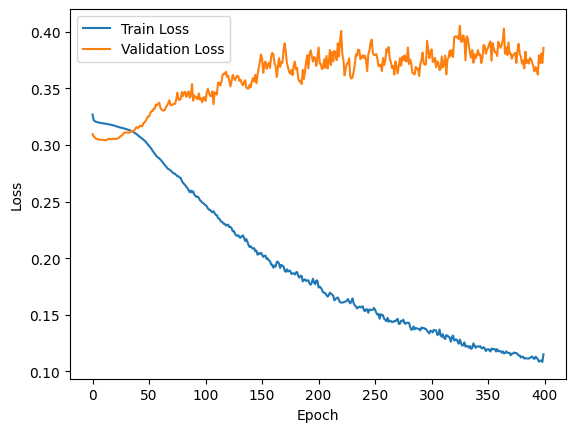

In [44]:
if TRAIN_2:
    plot_losses(train_losses, val_losses)

## Testing

In [45]:
data = train_dataset[0]
out = model(data.x, data.edge_index, data.edge_attr, data.coord, data.vel)
out

tensor([[0.1281, 0.0238],
        [0.1242, 0.0201],
        [0.1344, 0.0273]], grad_fn=<AddmmBackward0>)

In [46]:
target = data.y[:, 2:]
target

tensor([[ 0.1999,  0.4708],
        [-0.1655, -0.4636],
        [-0.4726,  0.1432]])

In [47]:
test_trajectory, energy = load_trajectory(f'data/task1_2/train/trajectory_0.npz', task) # TODO remove

for i, particles in enumerate(test_trajectory):
    graph = create_graph_from_particles_task_2(particles, test_trajectory[i+1])
    pred = model(graph.x, graph.edge_index, graph.edge_attr, graph.coord, graph.vel)
    print(f'Predicted velocities: {pred}')
    print(f'True velocities: {particles[:, 2:4]}')
    print(f'target:\n {graph.y}')
    break

Predicted velocities: tensor([[-0.1506,  0.2995],
        [-0.0830,  0.4078],
        [-0.0914,  0.1570],
        [-0.1404,  0.2209]], grad_fn=<AddmmBackward0>)
True velocities: [[ 0.51611651 -0.06928145]
 [ 0.5342578  -0.12193773]
 [ 0.28795482  0.33377239]
 [ 0.25443658  0.42087594]]
target:
 tensor([[ 9.8588,  7.4987,  0.5365, -0.0638],
        [ 8.1218, 12.5985,  0.5805, -0.1000],
        [ 9.8448, 14.6538,  0.2439,  0.2979],
        [ 5.4018,  7.7485,  0.2318,  0.4293]])


In [48]:
import torch
import numpy as np

def predict_trajectory(model, particles, time_steps=40, time_step_size=0.5, box_length=20.0, cutoff_value=10.0):
    """
    Predicts the trajectory of particles using the given model.

    Args:
        model (nn.Module): The graph neural network model.
        particles (np.ndarray): A numpy array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
        time_steps (int): The number of time steps to predict.
        time_step_size (float): The size of each time step.
        box_length (float): The length of the simulation box (assumed to be a square).
        cutoff_value (float): The cutoff distance for interactions.

    Returns:
        np.ndarray: An array with shape (time_steps, num_particles, [pos_x, pos_y, vel_x, vel_y, charge])
                    representing the states of the particles at each time step.
    """
    trajectory = [particles.copy()]  # Initial state of particles
    
    for i in range(time_steps - 1):
        current_particles = trajectory[-1]

        test_trajectory, energy = load_trajectory(f'data/task1_2/train/trajectory_0.npz', task) # TODO remove
        
        # Assuming create_graph_from_particles_task_2 needs a numpy array
        graph = create_graph_from_particles_task_2(current_particles, box_length=box_length, cutoff_value=cutoff_value)

        # Convert numpy array to torch tensor
        # node_features = torch.tensor(graph.x, dtype=torch.float32)
        # edge_index = torch.tensor(graph.edge_index) 
        # edge_attr = torch.tensor(graph.edge_attr, dtype=torch.float32)

        node_features = graph.x.clone().detach().to(device)
        edge_index = graph.edge_index.clone().detach().to(device)
        edge_attr = graph.edge_attr.clone().detach().to(device)
        coord = graph.coord.clone().detach().to(device)
        vel = graph.vel.clone().detach().to(device)


        # Predict the next velocities of the particles (norm, sin, cos)
        with torch.no_grad():
            predicted_vel = model(node_features, edge_index, edge_attr, coord, vel)
            print(f"predicted_vel: {predicted_vel}")
            print(f"true_vel: {test_trajectory[i+1][:, 2:4]}")
            
            # print(f"Type of predicted_norm: {type(predicted_norm)}")
            # print(f"Type of predicted_sin: {type(predicted_sin)}")
            # print(f"Type of predicted_cos: {type(predicted_cos)}")
            # print(f"predicted_coord: {predicted_coord.shape}")
            # print(f"predicted_vel: {predicted_vel.shape}")
            # print(f"predicted_vel_norm: {np.sqrt(predicted_vel[:, 0]**2 + predicted_vel[:, 1]**2)}")
        
        # Update particle positions using the predicted velocities
        predicted_coord = coord + predicted_vel * time_step_size
        predicted_coord = apply_periodic_boundary(predicted_coord, box_length)

        # Update particle positions and velocities
        charge = current_particles[:, 4][:, np.newaxis]
        updated_particles = np.concatenate([predicted_coord.cpu().numpy(), predicted_vel.cpu().numpy(), charge], axis=1)
        # print(f"Type of updated_particles: {type(updated_particles)}")
        trajectory.append(updated_particles)

    trajectory_np = np.stack(trajectory)
    return trajectory_np

Train trajectory 0
predicted_vel: tensor([[-0.1506,  0.2995],
        [-0.0830,  0.4078],
        [-0.0914,  0.1570],
        [-0.1404,  0.2209]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.1436,  0.1807],
        [-0.2680,  0.2976],
        [-0.0925,  0.0577],
        [-0.1141,  0.0928]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[-0.1016,  0.1198],
        [-0.3215,  0.2738],
        [-0.0848,  0.0321],
        [-0.0951,  0.0522]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[-0.0785,  0.0844],
        [-0.3693,  0.2854],
        [-0.0816,  0.0232],
        [-0.0893,  0.0424]])
true_vel: [[ 0.58696519 -0.05010111]
 [ 0.67432963 -0.01942546]
 [ 0.14921381  0.17187191]
 [ 0.18225709  0.4610

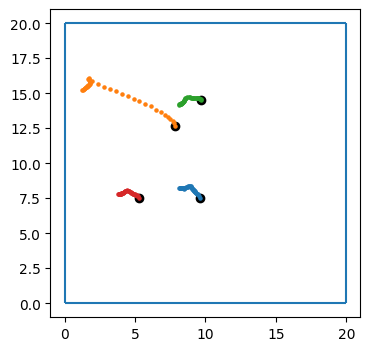

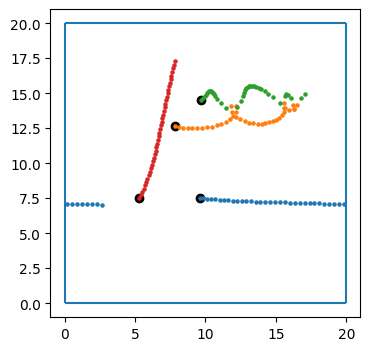

In [49]:
test_trajectory, energy = load_trajectory(f'data/task1_2/train/trajectory_0.npz', task)
test_particles = test_trajectory[0]
print(f"Train trajectory 0")
predicted_trajectory = predict_trajectory(model, test_particles)
plot_trajectory(predicted_trajectory)
plot_trajectory(test_trajectory)

Particle list: 39


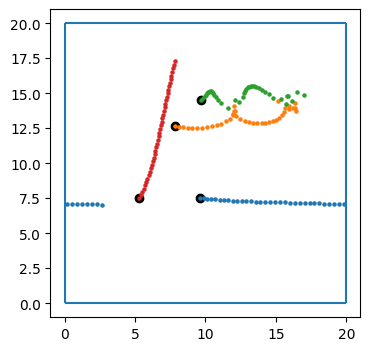

In [50]:
# Test that the dataset is correct
def plot_dataset_trajectory(trajectory, energy):

    particle_list = create_particle_data_list_task_2(trajectory, energies=energy)
    print(f"Particle list: {len(particle_list)}")

    trajectory = [trajectory[0]]
    charge = torch.tensor(trajectory[0][:, 4][:, np.newaxis], dtype=torch.float32).to(device)

    for i in range(39):

        graph = particle_list[i]
        # print(f"Graph: {graph}")

        node_features = graph.x.clone().detach().to(device)
        edge_index = graph.edge_index.clone().detach().to(device)
        edge_attr = graph.edge_attr.clone().detach().to(device)
        coord = graph.coord.clone().detach().to(device)
        vel = graph.vel.clone().detach().to(device)

        next_vel = graph.y.clone().detach().to(device)
        next_vel = next_vel[:, 2:]
        
        predicted_coord = coord + next_vel * 0.5
        predicted_coord = apply_periodic_boundary(predicted_coord, 20.0)


        updated_particles = torch.cat([predicted_coord, next_vel, charge], dim=1)
        trajectory.append(updated_particles)

    trajectory_np = np.stack(trajectory)
    plot_trajectory(trajectory_np)


plot_dataset_trajectory(test_trajectory, energy)


In [51]:
def compute_loss_trajectory(model, trajectory, criterion):
    """
    This function computes the loss of the given model on the given trajectory using the given loss function.
    It only considers the positions of the particles.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    trajectory (np.ndarray): The trajectory of the system.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first creates a graph representation of the trajectory. 
    Then, it computes the loss of the model on the trajectory using the given loss function. 
    Finally, it returns the loss.
    """
    particles = trajectory[0]
    predicted_trajectory = predict_trajectory(model, particles)

    # Consider only positions
    predicted_positions = predicted_trajectory[:, :, :2]
    true_positions = trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions, dtype=torch.float32), torch.tensor(true_positions, dtype=torch.float32))

    return loss.item()

compute_loss_trajectory(model, test_trajectory, criterion)

predicted_vel: tensor([[-0.1506,  0.2995],
        [-0.0830,  0.4078],
        [-0.0914,  0.1570],
        [-0.1404,  0.2209]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.1436,  0.1807],
        [-0.2680,  0.2976],
        [-0.0925,  0.0577],
        [-0.1141,  0.0928]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[-0.1016,  0.1198],
        [-0.3215,  0.2738],
        [-0.0848,  0.0321],
        [-0.0951,  0.0522]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[-0.0785,  0.0844],
        [-0.3693,  0.2854],
        [-0.0816,  0.0232],
        [-0.0893,  0.0424]])
true_vel: [[ 0.58696519 -0.05010111]
 [ 0.67432963 -0.01942546]
 [ 0.14921381  0.17187191]
 [ 0.18225709  0.46108381]]
predicted_ve

26.983673095703125

In [52]:
def compute_loss_time_step(model, data, criterion):
    """
    This function computes the loss of the given model on the given data for each time step using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    data (torch_geometric.data.Data): The data object containing the input features and target values.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the time steps in the data. 
    For each time step, it computes the predicted values using the model, computes the loss using the criterion, 
    and keeps track of the total loss over all time steps. Finally, it returns the average loss over all time steps.
    """
    model.eval()

    with torch.no_grad():
        node_features = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        coord = data.coord
        vel = data.vel
        target = data.y
        output = model(node_features, edge_index, edge_attr)
        loss = criterion(output, target)    

    return loss.item()

[970 991 942 946 971]
Test trajectory 970
predicted_vel: tensor([[-0.2620,  0.1109],
        [-0.0955,  0.2180],
        [-0.2917,  0.0867],
        [-0.1747, -0.0561],
        [-0.0158,  0.0187]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.1228,  0.1004],
        [-0.0315,  0.0034],
        [-0.1905,  0.1068],
        [-0.0975,  0.0057],
        [-0.0488, -0.0440]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[-0.1121,  0.0995],
        [-0.0362, -0.0063],
        [-0.2029,  0.1102],
        [-0.0785,  0.0151],
        [-0.0370, -0.0637]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[-0.1091,  0.0993],
        [-0.0345, -0.0042],
        [-0.2138,  0.1162],
        [-0.0705,  0.0227],
      

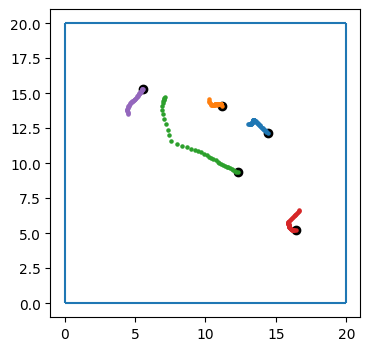

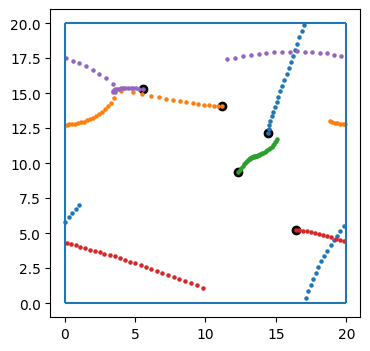

Test trajectory 991
predicted_vel: tensor([[ 0.0035, -0.0302],
        [-0.0069, -0.0231],
        [ 0.2461,  0.0148],
        [-0.0122, -0.1471]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.0074, -0.1004],
        [-0.0529, -0.1103],
        [ 0.1991, -0.1075],
        [-0.1536, -0.1450]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[ 0.0128, -0.1048],
        [-0.0267, -0.1166],
        [ 0.1836, -0.0917],
        [-0.1262, -0.1440]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[ 0.0149, -0.1066],
        [-0.0228, -0.1199],
        [ 0.1755, -0.0863],
        [-0.1309, -0.1389]])
true_vel: [[ 0.58696519 -0.05010111]
 [ 0.67432963 -0.01942546]
 [ 0.14921381  0.17187191]
 [ 0.18225709  0.461

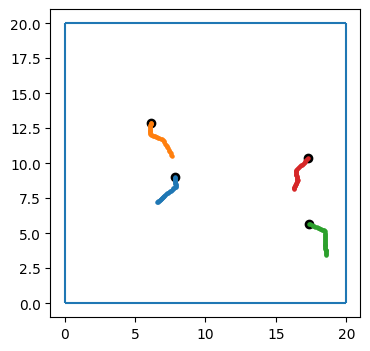

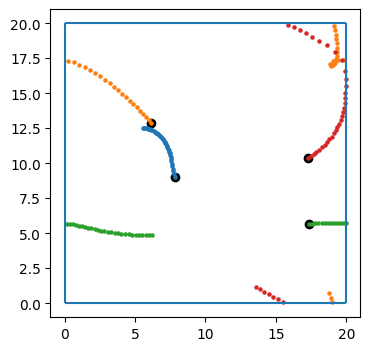

Test trajectory 942
predicted_vel: tensor([[-0.1641,  0.2014],
        [-0.2261,  0.1279],
        [ 0.2442,  0.0827],
        [ 0.0713,  0.3522],
        [-0.2623,  0.1697]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.1117,  0.0373],
        [-0.1300, -0.0471],
        [ 0.0273,  0.1016],
        [-0.0659,  0.1736],
        [-0.2104,  0.0495]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[-0.0676, -0.0370],
        [-0.0833, -0.0938],
        [-0.0576,  0.0828],
        [-0.0698,  0.0758],
        [-0.1644, -0.0028]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[-0.0573, -0.0530],
        [-0.0765, -0.1010],
        [-0.0882,  0.0983],
        [-0.0667,  0.0378],
        [-0.1448, -0.0227]])

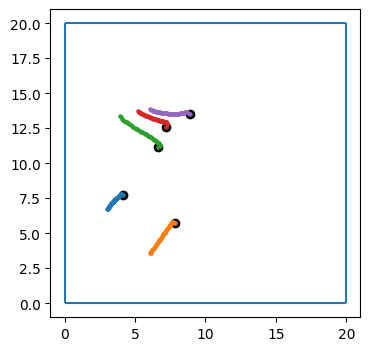

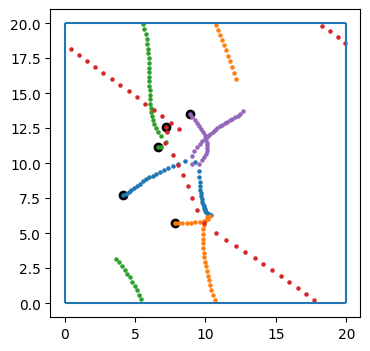

Test trajectory 946
predicted_vel: tensor([[ 0.1804, -0.1404],
        [ 0.1163, -0.1738],
        [ 0.1995, -0.2069]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[-0.0011, -0.1624],
        [ 0.0519, -0.1404],
        [ 0.0722, -0.2453]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[-0.0298, -0.1669],
        [ 0.0485, -0.1324],
        [ 0.0578, -0.2455]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[-0.0347, -0.1693],
        [ 0.0518, -0.1292],
        [ 0.0586, -0.2458]])
true_vel: [[ 0.58696519 -0.05010111]
 [ 0.67432963 -0.01942546]
 [ 0.14921381  0.17187191]
 [ 0.18225709  0.46108381]]
predicted_vel: tensor([[-0.0356, -0.1715],
        [ 0.0541, -0.1281],
        [ 0.0593, -0.2464]])
true

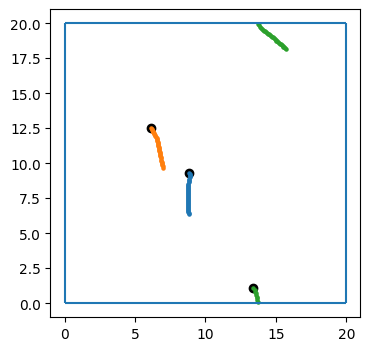

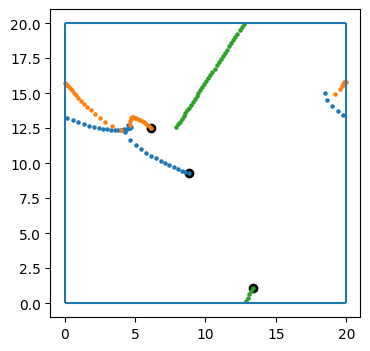

Test trajectory 971
predicted_vel: tensor([[ 0.2094, -0.2282],
        [ 0.3160, -0.1686],
        [ 0.1746, -0.2181]])
true_vel: [[ 0.53647451 -0.06382443]
 [ 0.58054579 -0.09997886]
 [ 0.24390343  0.29793727]
 [ 0.23184199  0.42929516]]
predicted_vel: tensor([[ 0.1071, -0.2451],
        [ 0.0333, -0.1714],
        [ 0.0773, -0.1133]])
true_vel: [[ 0.55510289 -0.05893923]
 [ 0.61908985 -0.076003  ]
 [ 0.20636183  0.25915418]
 [ 0.21221116  0.4392172 ]]
predicted_vel: tensor([[ 0.0660, -0.2474],
        [-0.0323, -0.1775],
        [ 0.0549, -0.1089]])
true_vel: [[ 0.57191848 -0.0544227 ]
 [ 0.6503136  -0.04936341]
 [ 0.17483044  0.21719141]
 [ 0.1957032   0.45002386]]
predicted_vel: tensor([[ 0.0659, -0.2468],
        [-0.0418, -0.1766],
        [ 0.0546, -0.1054]])
true_vel: [[ 0.58696519 -0.05010111]
 [ 0.67432963 -0.01942546]
 [ 0.14921381  0.17187191]
 [ 0.18225709  0.46108381]]
predicted_vel: tensor([[ 0.0659, -0.2463],
        [-0.0435, -0.1752],
        [ 0.0530, -0.1053]])
true

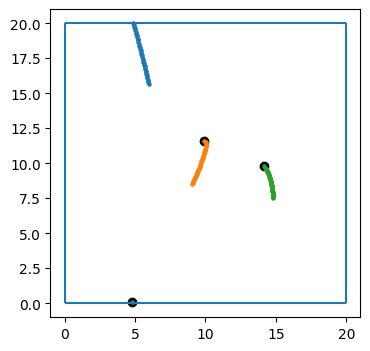

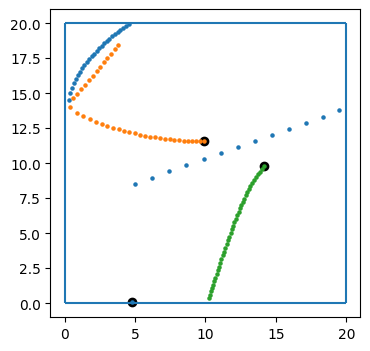

In [53]:
# Plot 5 random predictions from the test set
random_indices = np.random.randint(900, 1000, size=5)
random_indices[0] = 970 # TODO indice utile da includere nel report
print(random_indices)

for random_index in random_indices:
    test_trajectory, _ = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)
    test_particles = test_trajectory[0]
    print(f"Test trajectory {random_index}")
    predicted_trajectory = predict_trajectory(model, test_particles)
    plot_trajectory(predicted_trajectory)
    plot_trajectory(test_trajectory)

### MSE

Compute the MSE of the prediction of each data point

In [54]:
def compute_loss_time_step(model, data, criterion):
    """
    This function computes the loss of the given model on the given data for each time step using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    data (torch_geometric.data.Data): The data object containing the input features and target values.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the time steps in the data. 
    For each time step, it computes the predicted values using the model, computes the loss using the criterion, 
    and keeps track of the total loss over all time steps. Finally, it returns the average loss over all time steps.
    """
    model.eval()

    with torch.no_grad():
        node_features = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        target = data.y
        output = model(node_features, edge_index, edge_attr)
        loss = criterion(output, target)    

    return loss.item()

In [55]:
# Create a test dataset
test_paths = glob.glob('data/task1_2/test/*.npz')
test_dataset = ParticleDynamicsDataset(test_paths, max_len, box_length, cutoff, augment=False)
print(f'Test dataset: {len(test_dataset)} samples')

TypeError: ParticleDynamicsDataset.__init__() got an unexpected keyword argument 'augment'

In [ ]:
def compute_mean_loss(model, test_dataset, criterion):
    """
    This function computes the mean loss of the given model on the given test dataset using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    test_dataset (ParticleDynamicsDataset): The test dataset.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function iterates over the test dataset. For each data point, it computes the loss using the given model and loss function. 
    The function keeps track of the total loss over all data points. Finally, it returns the average loss over all data points.
    """
    total_loss = 0
    for data in test_dataset:
        total_loss += compute_loss_time_step(model, data, criterion)
    return total_loss / len(test_dataset)

criterion = torch.nn.MSELoss()
mean_loss = compute_mean_loss(model, test_dataset, criterion)
print(f'Mean loss on test set: {mean_loss}')

Mean loss on test set: 0.039604553941041024


Compute the MSE of the whole trajectory

In [ ]:
def compute_loss_trajectory(model, trajectory, criterion):
    """
    This function computes the loss of the given model on the given trajectory using the given loss function.
    It only considers the positions of the particles.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    trajectory (np.ndarray): The trajectory of the system.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first creates a graph representation of the trajectory. 
    Then, it computes the loss of the model on the trajectory using the given loss function. 
    Finally, it returns the loss.
    """
    particles = trajectory[0]
    predicted_trajectory = predict_trajectory(model, particles)

    # Consider only positions
    predicted_positions = predicted_trajectory[:, :, :2]
    true_positions = trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions, dtype=torch.float32), torch.tensor(true_positions, dtype=torch.float32))

    return loss.item()

In [ ]:
def compute_mean_loss_trajectory(model, test_paths, criterion):
    """
    Compute the mean loss across multiple trajectories.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): List of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between predicted and actual trajectories.

    Returns:
        float: The mean loss over all test trajectories.
    """
    total_loss = 0
    for path in test_paths:
        trajectory, _ = load_trajectory(path, task)
        loss = compute_loss_trajectory(model, trajectory, criterion)
        # print(f'Loss for trajectory {path}: {loss}')
        total_loss += loss
    return total_loss / len(test_paths)

mean_loss_trajectory = compute_mean_loss_trajectory(model, test_paths, criterion)
print(f'Mean loss on test set trajectories: {mean_loss_trajectory}')


Mean loss on test set trajectories: 29.245257525444032


### Rotation Equivariance

In [ ]:
import numpy as np

def rotate_particles(particles, angle_degrees, box_size=20):
    """
    Rotates the particles by the given angle in degrees.

    Args:
        particles (np.ndarray): A 2D numpy array representing the particles. Each row represents a particle, with columns for the particle's x and y coordinates, x and y velocities, and charge.
        angle_degrees (float): The angle by which to rotate the particles, in degrees. Positive values represent counter-clockwise rotation, and negative values represent clockwise rotation.

    Returns:
        np.ndarray: A 2D numpy array of the same shape as `particles`, representing the particles after rotation. The x and y coordinates and velocities of the particles have been rotated by `angle_degrees`, but the charges of the particles are unchanged.
    """
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Rotation matrix for 2D rotation
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])
    
    # Separate the components of the particles
    pos_x = particles[:, 0]
    pos_y = particles[:, 1]
    vel_x = particles[:, 2]
    vel_y = particles[:, 3]
    charge = particles[:, 4]
    
    # Apply rotation to positions
    positions = np.vstack((pos_x, pos_y))
    rotated_positions = rotation_matrix @ positions
    
    # Minimum image convention to ensure positions stay within the range [0, box_size]
    rotated_pos_x = (rotated_positions[0, :] + box_size) % box_size
    rotated_pos_y = (rotated_positions[1, :] + box_size) % box_size
    
    # Apply rotation to velocities
    velocities = np.vstack((vel_x, vel_y))
    rotated_velocities = rotation_matrix @ velocities
    rotated_vel_x = rotated_velocities[0, :]
    rotated_vel_y = rotated_velocities[1, :]
    
    # Combine the rotated components back into the particles array
    rotated_particles = np.vstack((rotated_pos_x, rotated_pos_y, rotated_vel_x, rotated_vel_y, charge)).T
    
    return rotated_particles

970
Test trajectory 970


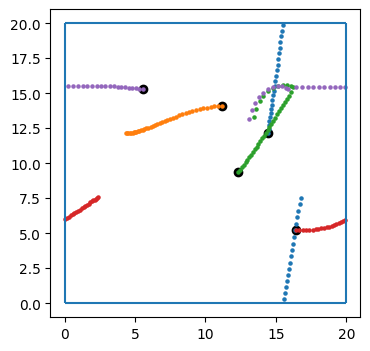

Rotated by 30 degrees


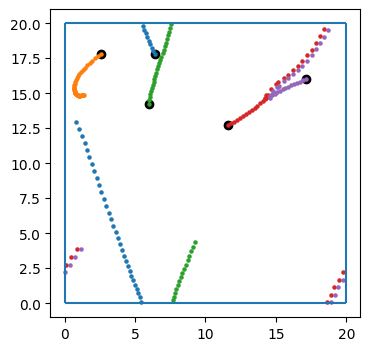

Rotated by 90 degrees


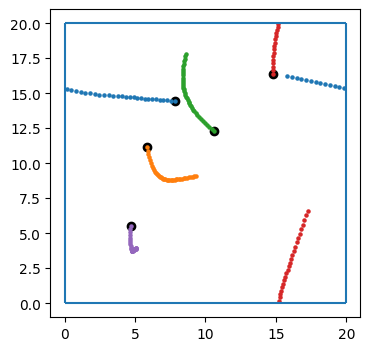

Rotated by 150 degrees


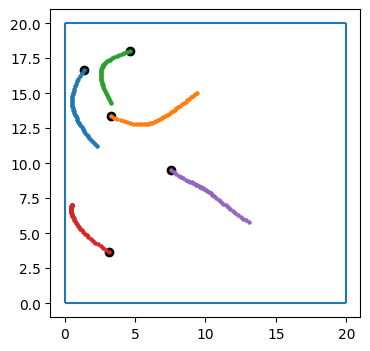

In [ ]:
# Plot a random prediction from the test set after rotating the particles by 30, 90, and 150 degrees
random_index = np.random.randint(900, 1000)
angles = [30, 90, 150]
random_index = 970 # TODO indice utile da includere nel report
print(random_index)

test_trajectory, _ = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)

def plot_predicted_rotations(trajectory, angles):
    """
    Plot the predicted trajectories of particles before and after applying rotations.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_trajectory (numpy.ndarray): The initial trajectory of particles with shape (timesteps, num_particles, 5).
        angles (list of float): The list of angles in degrees by which to rotate the particles.
    """
    test_particles = test_trajectory[0]

    print(f"Test trajectory {random_index}")
    predicted_trajectory = predict_trajectory(model, test_particles)
    plot_trajectory(predicted_trajectory)

    for angle in angles:
        rotated_particles = rotate_particles(test_particles, angle)
        print(f"Rotated by {angle} degrees")
        rotated_predicted_trajectory = predict_trajectory(model, rotated_particles)
        plot_trajectory(rotated_predicted_trajectory)

plot_predicted_rotations(test_trajectory, angles)

In [ ]:
def compute_rotation_loss(model, particles, criterion, angle_degrees):
    """
    Compute the rotation loss for a given model and set of particles.
    
    Parameters:
    model: The model used to predict the trajectory.
    particles: The initial state of the particles.
    criterion: The loss function used to compute the loss.
    angle_degrees: The angle by which to rotate the particles.

    Returns:
    The computed loss as a float.
    """
    
    # Predict the trajectory for the original particles and rotate it
    predicted_trajectory = predict_trajectory(model, particles)
    predicted_trajectory_rotated = [rotate_particles(particles, angle_degrees) for particles in predicted_trajectory]
    predicted_trajectory_rotated = np.stack(predicted_trajectory_rotated)

    # Rotate the particles and predict the trajectory
    rotated_particles = rotate_particles(particles, angle_degrees)
    rotated_predicted_trajectory = predict_trajectory(model, rotated_particles)
    
    # Consider only positions
    predicted_positions_1 = predicted_trajectory_rotated[:, :, :2]
    predicted_positions_2 = rotated_predicted_trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions_1, dtype=torch.float32), torch.tensor(predicted_positions_2, dtype=torch.float32))
    return loss.item()

def compute_mean_rotation_loss(model, test_paths, criterion, angle_degrees_list):
    """
    Compute the mean rotation loss for a given model and set of test paths.
    
    Parameters:
    model: The model used to predict the trajectory.
    test_paths: The paths to the test data.
    criterion: The loss function used to compute the loss.
    angle_degrees_list: A list of angles by which to rotate the particles.

    Returns:
    The mean computed loss as a float.
    """
    total_loss = 0
    for path in tqdm(test_paths, desc='Computing rotation loss'):
        trajectory, _ = load_trajectory(path, task)
        particles = trajectory[0]
        for angle_degrees in angle_degrees_list:
            loss = compute_rotation_loss(model, particles, criterion, angle_degrees)
            total_loss += loss
    return total_loss / (len(test_paths) * len(angle_degrees_list))

angle_degrees_list = [30, 90, 150]
mean_rotation_loss = compute_mean_rotation_loss(model, test_paths, criterion, angle_degrees_list)
print(f'Mean rotation loss on test set: {mean_rotation_loss}')

Computing rotation loss: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

Mean rotation loss on test set: 28.588281508286794


### Position Invariance

In [ ]:
import numpy as np

def shift_particles(particles, shift_vector):
    """
    Shifts the positions of particles by a given vector, wrapping around within a range of [0, 20].
    
    Parameters:
    particles: A numpy array of shape (num_particles, 5), where each row represents a particle and the columns represent the x position, y position, x velocity, y velocity, and charge, respectively.
    shift_vector: A numpy array of shape (2,) representing the x and y components of the shift vector.

    Returns:
    A numpy array of shape (num_particles, 5) representing the shifted particles.
    """
    # Separate the components of the particles
    pos_x = particles[:, 0]
    pos_y = particles[:, 1]
    vel_x = particles[:, 2]
    vel_y = particles[:, 3]
    charge = particles[:, 4]
    
    # Apply the shift vector to the positions
    shifted_pos_x = pos_x + shift_vector[0]
    shifted_pos_y = pos_y + shift_vector[1]
    
    # Ensure the positions stay within the range [0, 20] by wrapping around
    shifted_pos_x = np.mod(shifted_pos_x, 20)
    shifted_pos_y = np.mod(shifted_pos_y, 20)
    
    # Combine the shifted positions with the unchanged velocities and charges
    shifted_particles = np.vstack((shifted_pos_x, shifted_pos_y, vel_x, vel_y, charge)).T
    
    return shifted_particles

970
Shift vector: [ 6.34440107 14.73502816]


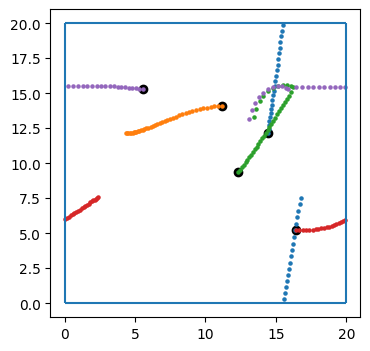

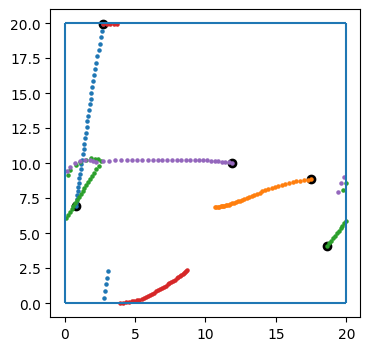

In [ ]:
# Plot a random prediction from the test set after rotating the particles by 30, 90, and 150 degrees
random_index = np.random.randint(900, 1000)
random_index = 970 # TODO indice utile da includere nel report
print(random_index)

# Generate a random shift vector for x and y within the range [0, 20]
shift_vector = np.random.uniform(0, 20, size=2)
print(f"Shift vector: {shift_vector}")

test_trajectory, _ = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)

def plot_predicted_shifts(test_trajectory, shift_vector):
    """
    Plot the predicted trajectories of particles before and after applying a shift.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_trajectory (numpy.ndarray): The initial trajectory of particles with shape (timesteps, num_particles, 5).
        shift_vector (numpy.ndarray): The vector by which to shift the particles.
    """
    test_particles = test_trajectory[0]
    predicted_trajectory = predict_trajectory(model, test_particles)
    plot_trajectory(predicted_trajectory)

    shifted_particles = shift_particles(test_particles, shift_vector)
    shifted_predicted_trajectory = predict_trajectory(model, shifted_particles)
    plot_trajectory(shifted_predicted_trajectory)

plot_predicted_shifts(test_trajectory, shift_vector)

In [ ]:
def compute_shift_loss(model, particles, criterion, shift_vector):
    """
    Compute the shift loss between the predicted trajectories of the original
    and shifted particles.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        particles (numpy.ndarray): The initial array of particles with shape (num_particles, 5).
        criterion (callable): The loss function to compute the difference between trajectories.
        shift_vector (numpy.ndarray): The vector by which to shift the particles.

    Returns:
        float: The computed shift loss.
    """
    # Predict the trajectory and shift it
    predicted_trajectory = predict_trajectory(model, particles)
    shifted_trajectory = [shift_particles(particles, shift_vector) for particles in predicted_trajectory]
    shifted_trajectory = np.stack(shifted_trajectory)

    # Shift the particles and predict the trajectory
    shifted_particles = shift_particles(particles, shift_vector)
    shifted_predicted_trajectory = predict_trajectory(model, shifted_particles)
    
    # Consider only positions
    predicted_positions_1 = shifted_trajectory[:, :, :2]
    predicted_positions_2 = shifted_predicted_trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions_1, dtype=torch.float32), torch.tensor(predicted_positions_2, dtype=torch.float32))
    return loss.item()

def compute_mean_shift_loss(model, test_paths, criterion, shift_vector):
    """
    Compute the mean shift loss across multiple test paths.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): The list of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between trajectories.
        shift_vector (numpy.ndarray): The vector by which to shift the particles.

    Returns:
        float: The mean shift loss over all test paths.
    """
    total_loss = 0
    for path in tqdm(test_paths, desc='Computing shift loss'):
        trajectory, _ = load_trajectory(path, task)
        particles = trajectory[0]
        loss = compute_shift_loss(model, particles, criterion, shift_vector)
        total_loss += loss
    return total_loss / len(test_paths)


mean_shift_loss = compute_mean_shift_loss(model, test_paths, criterion, shift_vector)
print(f'Mean shift loss on test set: {mean_shift_loss}')

Computing shift loss: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]

Mean shift loss on test set: 1.379931902079079e-10


# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [ ]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

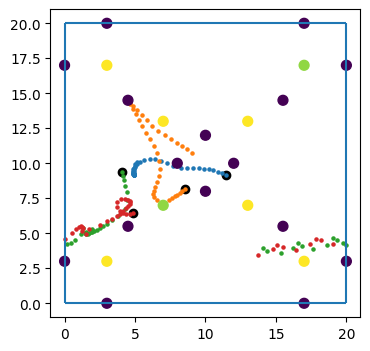

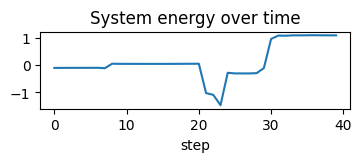

In [ ]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.